In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

from joblib import dump, load
import pickle

def Graph_Confusion_Matrix(CM, labels, title = 'Confusion Matrix'):
    #np.fill_diagonal(CM,0)

    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(CM, annot=True,annot_kws={"size": 16},  fmt='.1f' # fmt='g'
               ,xticklabels = labels
               ,yticklabels = labels)# font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


plt.style.use('bmh')


In [2]:
font = {'size'   : 10}
matplotlib.rc('font', **font)
#path = "C:\\Users\\Jack\\OneDrive\\Uni Work\\Project\\Dashboard Trial.xlsx"
path = "Data/Train_Data_Aft_FE.csv"
df = pd.read_csv(path)
df = df.set_index("URN")

K_mean = load('Parameter_Dictionary/k-means.joblib') 

#Load dictionary that has mean and std for k-means
with open('Parameter_Dictionary/K_means_Dict.pickle', 'rb') as handle:
    Para_Dict = pickle.load(handle)


## Need to add on the customer segments

In [3]:
df_k_means = df[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means["Recency"] = np.where((df_k_means['NUM_TRANS_LST_24']>0),1,0)

X_k_means = (df_k_means.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [4]:
df = pd.concat([df,pd.Series(K_mean.predict(X_k_means), index=df.index)],axis=1)
df.rename(columns={0:"Clusters"}, inplace=True)

In [5]:
df.head(5)

,DV,INCOME,APPEAL_AVG_GIFT,EMERG_AVG_GIFT,EMAIL_FLAG,NUM_ACTIVE_COG,NUM_ATTRITED_COG,NUM_DIFF_COG,TOTAL_YEARLY_CHARGE,TOTAL_NUM_MONTH_PAID,...,SEXC1,TITLEC1,TOWNC1,OAC_GroupC1,Mosaic GroupC1,COG_TYPEC1,WRR_EMERG,WRR_APP,Total_C1,Clusters
URN,,,,,,,,,,,,,,,,,,,,,
87281,0,NaN,0.00,0.0,1,0,0,0,0.0,0,...,0,0,0,0,0,0,-1.000000,-3.00,0.000000,4
28497,0,NaN,55.00,0.0,0,0,1,0,0.0,0,...,0,0,0,1,0,0,0.000000,1.25,1.166667,4
58676,0,NaN,0.00,0.0,0,0,1,0,0.0,0,...,0,1,0,0,0,0,-2.000000,-3.00,1.166667,4
14806,0,NaN,0.00,65.0,0,1,0,1,120.0,456,...,0,1,0,0,0,1,2.400000,-7.00,2.333333,3
8548,0,NaN,81.68,50.0,0,1,0,1,180.0,260,...,0,0,0,0,1,1,2.333333,1.10,2.333333,2


In [23]:
Num_DV_1 = len(df.loc[df["DV"] == 1])

df_final = pd.concat([df.loc[df["DV"] == 1], df.loc[df["DV"] == 0].sample(Num_DV_1, random_state=32)]).copy()
df_final = df_final.sample(frac=1, random_state=53)#.reset_index(drop=True)

In [24]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19036 entries, 87358 to 28144
Data columns (total 31 columns):
DV                                    19036 non-null int64
INCOME                                9518 non-null float64
APPEAL_AVG_GIFT                       19036 non-null float64
EMERG_AVG_GIFT                        19036 non-null float64
EMAIL_FLAG                            19036 non-null int64
NUM_ACTIVE_COG                        19036 non-null int64
NUM_ATTRITED_COG                      19036 non-null int64
NUM_DIFF_COG                          19036 non-null int64
TOTAL_YEARLY_CHARGE                   19036 non-null float64
TOTAL_NUM_MONTH_PAID                  19036 non-null int64
DM_PREVIOUS_12_MONTHS                 19036 non-null int64
NUM_TRANS_LST_24                      19036 non-null int64
DONATED_LST_24                        19036 non-null float64
Months Between DateCr and Last Ask    19036 non-null float64
Mosaic Group Num                      19036 non-nu

In [25]:
X = df_final.drop(["DV","INCOME"], axis=1).copy()

y = df_final["DV"].copy()

In [ ]:
#X.drop(["EMAIL_FLAG", "PHONE_FLAG", "SMS_FLAG", "ALL_CHANNEL_OPT_IN"], axis=1, inplace=True)

In [26]:
X.head(5)

,APPEAL_AVG_GIFT,EMERG_AVG_GIFT,EMAIL_FLAG,NUM_ACTIVE_COG,NUM_ATTRITED_COG,NUM_DIFF_COG,TOTAL_YEARLY_CHARGE,TOTAL_NUM_MONTH_PAID,DM_PREVIOUS_12_MONTHS,NUM_TRANS_LST_24,...,SEXC1,TITLEC1,TOWNC1,OAC_GroupC1,Mosaic GroupC1,COG_TYPEC1,WRR_EMERG,WRR_APP,Total_C1,Clusters
URN,,,,,,,,,,,,,,,,,,,,,
87358,0.0,0.0,0,0,0,0,0.0,0,-1,0,...,0,0,1,1,1,0,-1.000000,-3.000000,3.500000,1
61037,62.5,0.0,0,1,0,1,234.0,99,6,24,...,0,0,0,0,0,1,-4.000000,2.222222,1.166667,3
32157,20.0,40.0,0,2,0,1,300.0,279,6,48,...,0,0,0,0,1,1,1.166667,1.090909,2.333333,2
113322,0.0,0.0,1,0,0,0,0.0,0,6,2,...,0,0,1,1,1,0,0.000000,0.000000,3.500000,1
68043,0.0,0.0,0,2,0,1,144.0,109,-1,30,...,0,1,0,1,1,1,-2.000000,-3.000000,4.666667,2


LE = LabelEncoder()
X["AGE_DESC"] = LE.fit_transform(X["AGE_DESC"])
X["MOSAIC_GROUP_DESC"] = LE.fit_transform(X["MOSAIC_GROUP_DESC"])
X["TOWN"] = LE.fit_transform(X["TOWN"])

In [27]:
importance_df = pd.read_csv("Data/Feature_Importance.csv", index_col = 0)

## The below cell was ised to build the feature importance and is used ot build the final mode one we have done all our test in the sections below

In [35]:
#features = X.columns
features = importance_df.head(13).index

#importance_df = pd.DataFrame(index=features)

Acc_Train = []
Acc = []
Recall = []
Precision = []

#Parameters for model:
lgb_params = {'num_leaves': 24, #max number of leaves in one tree
             'min_data_in_leaf': 25, #minimal number of data in one leaf. Can be used to deal with over-fitting
             'objective':'binary',
             #'max_depth': 10,
             'learning_rate': 0.1, #How much each tree effects the overall result.
             "boosting": "gbdt",
             "feature_fraction": 0.8, #LightGBM will select X% of features before training each tree
             "bagging_freq": 1,
             "bagging_fraction": 1, #like feature_fraction, but this will randomly select part of data without resampling
             "bagging_seed": 42,
             "metric": 'AUC',
             "lambda_l2": 0.25,
             "num_threads": 2,
             "verbosity": -1}


folds = KFold(n_splits=10, shuffle=False)
#oof_lgb = np.zeros(len(X_train))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):    
    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx], categorical_feature=(6,8))
    val_data = lgb.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx], categorical_feature=(6,8))

    num_round = 500
    clf = lgb.train(lgb_params, trn_data, num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval= 100, 
                    categorical_feature=(14,15,16,17,18,29),
                    early_stopping_rounds = 25) #less than 0 means disable
    
    #Feature Importance
    #importance_df["importance"+str(fold_ + 1)] = clf.feature_importance(importance_type='gain')
    
    predictions_lgb = np.zeros(len(y.iloc[val_idx]))
    predictions_lgb = clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    Y_actual = y.iloc[val_idx]
    
    Acc_Train.append(accuracy_score(y.iloc[trn_idx], clf.predict(X.iloc[trn_idx][features], num_iteration=clf.best_iteration) >=0.5 )*100)

    Acc.append(accuracy_score(Y_actual,  predictions_lgb > 0.5)*100)
    Recall.append(recall_score(Y_actual,  predictions_lgb > 0.5)*100)
    Precision.append(precision_score(Y_actual,  predictions_lgb > 0.5)*100)
    
    if fold_ == 0:
        Outcome_df = pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(predictions_lgb, index=X.iloc[val_idx].index)],axis=1)
    else:
        Outcome_df = Outcome_df.append(pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(predictions_lgb, index=X.iloc[val_idx].index)],axis=1), sort=False)
        
        
Outcome_df.rename(index=str, columns={0:"Score"}, inplace=True)

print("")
print("Avg Accuracy Train Set:", np.mean(Acc_Train))
print("Avg Accuracy Test Set:",np.mean(Acc))
print("")
print("Avg Recall:",np.mean(Recall))
print("Avg Precision:",np.mean(Precision))

Outcome_df.to_csv("Model Outputs/LightGBM.csv", index=True)

-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.913119	valid_1's auc: 0.888154
Early stopping, best iteration is:
[124]	training's auc: 0.919138	valid_1's auc: 0.888657
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[59]	training's auc: 0.900727	valid_1's auc: 0.888705
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.91381	valid_1's auc: 0.885592
Early stopping, best iteration is:
[124]	training's auc: 0.919496	valid_1's auc: 0.886091
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.905841	valid_1's auc: 0.875885
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.914341	valid_1's auc: 0.876723
Early stopping, best iteration is:
[127]	training's auc: 0.920358	valid_1's auc: 0.877728
-
Fold 6
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.913524	valid_1's auc: 0.880034
Early stopping, best iteration is:
[124]	training's auc: 0.919748	valid_1's auc: 0.880773
-
Fold 7
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.906211	valid_1's auc: 0.887788
-
Fold 8
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.913257	valid_1's auc: 0.885035
Early stopping, best iteration is:
[84]	training's auc: 0.908813	valid_1's auc: 0.88539
-
Fold 9
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.912248	valid_1's auc: 0.897818
Early stopping, best iteration is:
[77]	training's auc: 0.905572	valid_1's auc: 0.898356
-
Fold 10
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 15, 16, 17, 18, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's auc: 0.912854	valid_1's auc: 0.886073
Early stopping, best iteration is:
[95]	training's auc: 0.911521	valid_1's auc: 0.886375

Avg Accuracy Train Set: 83.00297483781792
Avg Accuracy Test Set: 80.3058058483509

Avg Recall: 78.25541617461029
Avg Precision: 81.60972426191309


Confusion Matrix to see how the model is doing.

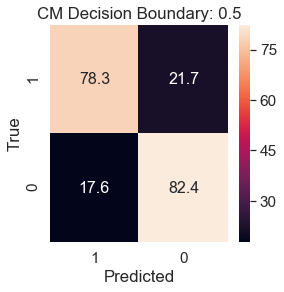

In [29]:
Boundry = 0.5
labels=[1,0]

CM = confusion_matrix(Outcome_df["DV"], Outcome_df["Score"]>=Boundry, labels)

#Normalise so is a percentage
CM = np.divide(CM,np.sum(CM, axis=1).reshape(2,-1)) * 100

Graph_Confusion_Matrix(CM, labels, 'CM Decision Boundary: '+str(Boundry))

### Light GBM can tell you the most informative features. This cycles through them random in Gain to find the best model

In [11]:
Train_Acc = []
Test_Acc = []
Test_Recall = []

#for j in range(1,11):
for i in range(1,X.shape[1]):
    
    features = importance_df.head(i).index
    
    Acc_Train = []
    Acc = []
    Recall = []
    Precision = []

    #Parameters for model:
    lgb_params = {'num_leaves': 16,
                 'min_data_in_leaf': 10, 
                 'objective':'binary',
                 #'max_depth': 10,
                 'learning_rate': 0.1,
                 "boosting": "gbdt",
                 "feature_fraction": 0.8,
                 "bagging_freq": 1,
                 "bagging_fraction": 1,
                 "bagging_seed": 42,
                 "metric": 'AUC',
                 #"lambda_l1": 0.0,
                 "verbosity": -1}


    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    #oof_lgb = np.zeros(len(X_train))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):    

        print('-')
        print("Fold {}".format(fold_ + 1))
        trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx], categorical_feature=(14,15,16,17,18,29))
        val_data = lgb.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx], categorical_feature=(14,15,16,17,18,29))

        num_round = 500
        clf = lgb.train(lgb_params, trn_data, num_round, 
                        valid_sets = [trn_data, val_data]
                        ,verbose_eval=200
                        ,categorical_feature=(14,15,16,17,18,29)
                        ,early_stopping_rounds=25)

        predictions_lgb = np.zeros(len(y.iloc[val_idx]))
        predictions_lgb = clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration)

        Y_actual = y.iloc[val_idx]

        Acc_Train.append(accuracy_score(y.iloc[trn_idx], clf.predict(X.iloc[trn_idx][features], num_iteration=clf.best_iteration) >=0.5 )*100)

        Acc.append(accuracy_score(Y_actual,  predictions_lgb > 0.5)*100)
        Recall.append(recall_score(Y_actual,  predictions_lgb > 0.5)*100)
        Precision.append(precision_score(Y_actual,  predictions_lgb > 0.5)*100)

    print("")
    print("Avg Accuracy Train Set:", np.mean(Acc_Train))
    print("Avg Accuracy Test Set:",np.mean(Acc))
    print("")
    print("Avg Recall:",np.mean(Recall))
    print("Avg Precision:",np.mean(Precision))

    Train_Acc.append(np.mean(Acc_Train))
    Test_Acc.append(np.mean(Acc))
    Test_Recall.append(np.mean(Recall))

-
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.735739	valid_1's auc: 0.740227
-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[21]	training's auc: 0.735789	valid_1's auc: 0.737368
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[26]	training's auc: 0.737932	valid_1's auc: 0.731419
-
Fold 4
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[24]	training's auc: 0.735902	valid_1's auc: 0.739601
-
Fold 5
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[9]	training's auc: 0.740262	valid_1's auc: 0.718554

Avg Accuracy Train Set: 71.23870265837184
Avg Accuracy Test Set: 71.21764722437437

Avg Recall: 56.22427799772165
Avg Precision: 80.31392806883848
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[79]	training's auc: 0.836825	valid_1's auc: 0.836078
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[43]	training's auc: 0.836579	valid_1's auc: 0.833001
-
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[49]	training's auc: 0.836416	valid_1's auc: 0.83188
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.837005	valid_1's auc: 0.835441
-
Fold 5
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[37]	training's auc: 0.836255	valid_1's auc: 0.831865

Avg Accuracy Train Set: 76.43806144329828
Avg Accuracy Test Set: 76.25021383651963

Avg Recall: 71.47309807905897
Avg Precision: 79.02288478471871
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[44]	training's auc: 0.859616	valid_1's auc: 0.860483
-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[68]	training's auc: 0.864803	valid_1's auc: 0.855991
-
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[129]	training's auc: 0.871354	valid_1's auc: 0.854934

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[164]	training's auc: 0.872856	valid_1's auc: 0.859167
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.868799	valid_1's auc: 0.853048

Avg Accuracy Train Set: 78.69824591742322
Avg Accuracy Test Set: 77.69489198358617

Avg Recall: 71.93413563165973
Avg Precision: 81.30153960331498
-
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[57]	training's auc: 0.862478	valid_1's auc: 0.859677


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[116]	training's auc: 0.871779	valid_1's auc: 0.855563
-
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[69]	training's auc: 0.865421	valid_1's auc: 0.852034

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 4
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[130]	training's auc: 0.873338	valid_1's auc: 0.856517
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.870705	valid_1's auc: 0.85311

Avg Accuracy Train Set: 78.71532317847881
Avg Accuracy Test Set: 77.65284896464496

Avg Recall: 72.03831981072963
Avg Precision: 81.15065590515698
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[112]	training's auc: 0.883932	valid_1's auc: 0.868684
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[150]	training's auc: 0.888799	valid_1's auc: 0.865801
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[169]	training's auc: 0.890048	valid_1's auc: 0.864347
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.879033	valid_1's auc: 0.866511
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[146]	training's auc: 0.889313	valid_1's auc: 0.863533

Avg Accuracy Train Set: 80.25057271612579
Avg Accuracy Test Set: 78.62467386481781

Avg Recall: 74.82462150255014
Avg Precision: 80.98371889111588
-
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[57]	training's auc: 0.875296	valid_1's auc: 0.868302

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[69]	training's auc: 0.877762	valid_1's auc: 0.865857
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.889085	valid_1's auc: 0.86433
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.884549	valid_1's auc: 0.868058
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.885966	valid_1's auc: 0.864845

Avg Accuracy Train Set: 80.1100465129131
Avg Accuracy Test Set: 78.71397889336978

Avg Recall: 75.2266291143081
Avg Precision: 80.86918354167372
-
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[67]	training's auc: 0.879021	valid_1's auc: 0.867376

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[65]	training's auc: 0.877967	valid_1's auc: 0.865308

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[69]	training's auc: 0.879214	valid_1's auc: 0.8625

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 4
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[77]	training's auc: 0.88104	valid_1's auc: 0.866182
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.888995	valid_1's auc: 0.863281

Avg Accuracy Train Set: 79.99448063736801
Avg Accuracy Test Set: 78.6036668410469

Avg Recall: 75.47622536717894
Avg Precision: 80.51562149795022
-
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[51]	training's auc: 0.877634	valid_1's auc: 0.872162

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[82]	training's auc: 0.885668	valid_1's auc: 0.869166
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[113]	training's auc: 0.89132	valid_1's auc: 0.867782
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.885144	valid_1's auc: 0.869623
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.888007	valid_1's auc: 0.868154

Avg Accuracy Train Set: 80.30309975870867
Avg Accuracy Test Set: 78.82954994448527

Avg Recall: 75.31825363930997
Avg Precision: 81.01148616948191
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.890742	valid_1's auc: 0.875714
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.900206	valid_1's auc: 0.875301
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.898144	valid_1's auc: 0.87417
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[133]	training's auc: 0.899806	valid_1's auc: 0.877625
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[122]	training's auc: 0.899536	valid_1's auc: 0.874994

Avg Accuracy Train Set: 81.36818841149277
Avg Accuracy Test Set: 79.32337572538866

Avg Recall: 76.04619493050119
Avg Precision: 81.38920700660776
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.901161	valid_1's auc: 0.878627
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[167]	training's auc: 0.91309	valid_1's auc: 0.879857
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[131]	training's auc: 0.907336	valid_1's auc: 0.879244
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.918382	valid_1's auc: 0.88264
Early stopping, best iteration is:
[181]	training's auc: 0.91509	valid_1's auc: 0.883198
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.909186	valid_1's auc: 0.880476

Avg Accuracy Train Set: 82.63683537362348
Avg Accuracy Test Set: 79.85922659055743

Avg Recall: 77.04362205159379
Avg Precision: 81.64303114332309
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[110]	training's auc: 0.90443	valid_1's auc: 0.878532
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.904382	valid_1's auc: 0.880726
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[121]	training's auc: 0.906252	valid_1's auc: 0.878305
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[130]	training's auc: 0.906726	valid_1's auc: 0.884094
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[146]	training's auc: 0.910711	valid_1's auc: 0.879137

Avg Accuracy Train Set: 82.38994352620651
Avg Accuracy Test Set: 79.98528528826819

Avg Recall: 76.90749155923807
Avg Precision: 81.95603579056608
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.901702	valid_1's auc: 0.8804
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[146]	training's auc: 0.913759	valid_1's auc: 0.883298
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.904763	valid_1's auc: 0.87902
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.912262	valid_1's auc: 0.886541
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.913909	valid_1's auc: 0.881273

Avg Accuracy Train Set: 82.68411661125916
Avg Accuracy Test Set: 79.95378371994975

Avg Recall: 77.07412820958169
Avg Precision: 81.78580080814403
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[126]	training's auc: 0.911832	valid_1's auc: 0.880211
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[117]	training's auc: 0.908735	valid_1's auc: 0.88513
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[155]	training's auc: 0.917537	valid_1's auc: 0.881724
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[165]	training's auc: 0.918375	valid_1's auc: 0.888907
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.924354	valid_1's auc: 0.883798
Early stopping, best iteration is:
[190]	training's auc: 0.922852	valid_1's auc: 0.884017

Avg Accuracy Train Set: 83.42350888164702
Avg Accuracy Test Set: 80.38979362430553

Avg Recall: 78.32648068469013
Avg Precision: 81.7045912879736
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.904871	valid_1's auc: 0.880532
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[160]	training's auc: 0.918224	valid_1's auc: 0.884522
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[162]	training's auc: 0.918978	valid_1's auc: 0.881197
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.908596	valid_1's auc: 0.888934
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[137]	training's auc: 0.914412	valid_1's auc: 0.884888

Avg Accuracy Train Set: 83.059720195334
Avg Accuracy Test Set: 80.1954217463187

Avg Recall: 77.92629716747385
Avg Precision: 81.63452472044744
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.909319	valid_1's auc: 0.880686
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.912033	valid_1's auc: 0.884592
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.927461	valid_1's auc: 0.880819
Early stopping, best iteration is:
[175]	training's auc: 0.922788	valid_1's auc: 0.881153
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[117]	training's auc: 0.910443	valid_1's auc: 0.887477
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[113]	training's auc: 0.909988	valid_1's auc: 0.885009

Avg Accuracy Train Set: 83.00981859934568
Avg Accuracy Test Set: 80.11138261451154

Avg Recall: 77.79187304503661
Avg Precision: 81.58170540357989
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.908831	valid_1's auc: 0.873942
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.90865	valid_1's auc: 0.880588
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.913609	valid_1's auc: 0.875549
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909221	valid_1's auc: 0.879134
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[99]	training's auc: 0.914219	valid_1's auc: 0.879518

Avg Accuracy Train Set: 82.86404529756496
Avg Accuracy Test Set: 79.75414732480857

Avg Recall: 77.4071205722864
Avg Precision: 81.21324749359601
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[52]	training's auc: 0.900582	valid_1's auc: 0.87486
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[114]	training's auc: 0.917357	valid_1's auc: 0.879478
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[73]	training's auc: 0.908622	valid_1's auc: 0.875112
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.914025	valid_1's auc: 0.879139
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.909277	valid_1's auc: 0.879094

Avg Accuracy Train Set: 82.74189558192784
Avg Accuracy Test Set: 79.45997449413179

Avg Recall: 77.04921374890817
Avg Precision: 80.94616105205291
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[55]	training's auc: 0.902515	valid_1's auc: 0.873617
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.915432	valid_1's auc: 0.879998
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.91711	valid_1's auc: 0.875788
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.919938	valid_1's auc: 0.877953
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.917477	valid_1's auc: 0.878548

Avg Accuracy Train Set: 83.11355603723095
Avg Accuracy Test Set: 79.58081420117298

Avg Recall: 77.34557087602397
Avg Precision: 80.96072920809479
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.916711	valid_1's auc: 0.87337
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.927306	valid_1's auc: 0.879673
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.91314	valid_1's auc: 0.874119
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[51]	training's auc: 0.900174	valid_1's auc: 0.877516
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[55]	training's auc: 0.901799	valid_1's auc: 0.877846

Avg Accuracy Train Set: 82.82728335330943
Avg Accuracy Test Set: 79.49674471837594

Avg Recall: 77.04975816136398
Avg Precision: 81.00725687433751
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.906645	valid_1's auc: 0.874208
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.923343	valid_1's auc: 0.878543
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.907414	valid_1's auc: 0.876345
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.926773	valid_1's auc: 0.878078
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[105]	training's auc: 0.918585	valid_1's auc: 0.879901

Avg Accuracy Train Set: 83.30004915931636
Avg Accuracy Test Set: 79.47575149050951

Avg Recall: 77.22122455638942
Avg Precision: 80.86698395473698
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[66]	training's auc: 0.907691	valid_1's auc: 0.874897
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[126]	training's auc: 0.923588	valid_1's auc: 0.88112
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.909106	valid_1's auc: 0.874441
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.915221	valid_1's auc: 0.878933
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.918983	valid_1's auc: 0.879103

Avg Accuracy Train Set: 83.15296248742794
Avg Accuracy Test Set: 79.62808172914556

Avg Recall: 77.3769935486155
Avg Precision: 81.02123412969254
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[53]	training's auc: 0.902883	valid_1's auc: 0.87455
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.922827	valid_1's auc: 0.87982
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[61]	training's auc: 0.906214	valid_1's auc: 0.87358
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.917096	valid_1's auc: 0.878374
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.909757	valid_1's auc: 0.879338

Avg Accuracy Train Set: 82.85221444514627
Avg Accuracy Test Set: 79.49674057960458

Avg Recall: 77.15853009171904
Avg Precision: 80.94340967743034
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.906707	valid_1's auc: 0.874185
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[72]	training's auc: 0.907562	valid_1's auc: 0.880095
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[58]	training's auc: 0.903835	valid_1's auc: 0.875053
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[56]	training's auc: 0.902799	valid_1's auc: 0.87882
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.919924	valid_1's auc: 0.878021

Avg Accuracy Train Set: 82.48581566320584
Avg Accuracy Test Set: 79.51250378007784

Avg Recall: 76.87305667386974
Avg Precision: 81.1527931013122
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.911765	valid_1's auc: 0.874994
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.916277	valid_1's auc: 0.879438
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.914554	valid_1's auc: 0.876376
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[50]	training's auc: 0.899427	valid_1's auc: 0.877839
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[128]	training's auc: 0.924461	valid_1's auc: 0.878782

Avg Accuracy Train Set: 83.00325416356608
Avg Accuracy Test Set: 79.6333200340814

Avg Recall: 76.92547871377973
Avg Precision: 81.32618767734289
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[64]	training's auc: 0.906815	valid_1's auc: 0.874389
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.924595	valid_1's auc: 0.87992
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.918848	valid_1's auc: 0.876428
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[47]	training's auc: 0.898186	valid_1's auc: 0.879451
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.915561	valid_1's auc: 0.878533

Avg Accuracy Train Set: 83.02163366959023
Avg Accuracy Test Set: 79.55979200190714

Avg Recall: 77.10316441732735
Avg Precision: 81.08246644204054
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[73]	training's auc: 0.911264	valid_1's auc: 0.874962
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[129]	training's auc: 0.924968	valid_1's auc: 0.879714
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[56]	training's auc: 0.903467	valid_1's auc: 0.87476
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[56]	training's auc: 0.902779	valid_1's auc: 0.878377
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[68]	training's auc: 0.90721	valid_1's auc: 0.878947

Avg Accuracy Train Set: 82.72221064000374
Avg Accuracy Test Set: 79.544026042253

Avg Recall: 77.24219094853372
Avg Precision: 80.96701641591387
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[48]	training's auc: 0.899397	valid_1's auc: 0.874292
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.915497	valid_1's auc: 0.878666
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[68]	training's auc: 0.908357	valid_1's auc: 0.876042
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.903495	valid_1's auc: 0.878657
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.940394	valid_1's auc: 0.881535
Early stopping, best iteration is:
[200]	training's auc: 0.940394	valid_1's auc: 0.881535

Avg Accuracy Train Set: 83.0583931990869
Avg Accuracy Test Set: 79.50200095798762

Avg Recall: 77.25252721128754
Avg Precision: 80.88839953254929
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.905474	valid_1's auc: 0.873752
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[130]	training's auc: 0.925022	valid_1's auc: 0.879472
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.912374	valid_1's auc: 0.875178
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[54]	training's auc: 0.90161	valid_1's auc: 0.879288
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.913725	valid_1's auc: 0.878578

Avg Accuracy Train Set: 82.79311865471436
Avg Accuracy Test Set: 79.4179494098664

Avg Recall: 76.73744553415546
Avg Precision: 81.08050210607239


In [108]:
np.linspace(0.1,1,10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

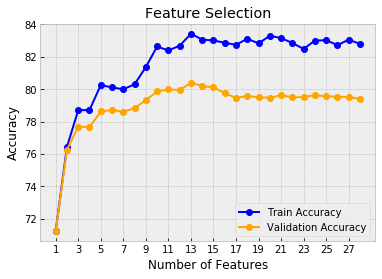

In [13]:
plt.plot(range(1,i+1), Train_Acc, linestyle='-', marker='o', color='b', label="Train Accuracy")
plt.plot(range(1,i+1), Test_Acc,  linestyle='-', marker='o', color='orange', label="Validation Accuracy")

plt.xticks(range(1,i+1,2))

plt.title("Feature Selection")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### What are best settings for the model?

We need to do a grid search but that is for sklearn only so I am doing 3 for loops

In [32]:
Best_Val_Acc = 0.0
Best_Parameter = {'num_leaves': "BLANK",
                  "min_data_in_leaf": "BLANK",
                  "feature_fraction": "BLANK"
                 }

features = importance_df.head(13).index

for num_leaves in range(8,33,8):
    for min_data_in_leaf in range(20,51,5):
        for feature_fraction in range(5,11):
            print(str(num_leaves) + " " + str(min_data_in_leaf) + " " + str(feature_fraction*0.1))

            Acc_Train = []
            Acc = []
            Recall = []
            Precision = []

            #Parameters for model:
            lgb_params = {'num_leaves': num_leaves,
                         'min_data_in_leaf': min_data_in_leaf, 
                         'objective':'binary',
                         #'max_depth': 10,
                         'learning_rate': 0.1,
                         "boosting": "gbdt",
                         "feature_fraction": feature_fraction*0.1,
                         "bagging_freq": 1,
                         "bagging_fraction": 1,
                         "bagging_seed": 42,
                         "metric": 'AUC',
                         "num_threads": 6,
                         #"lambda_l1": 0.0,
                         "verbosity": -1}


            folds = KFold(n_splits=5, shuffle=True, random_state=42)
            #oof_lgb = np.zeros(len(X_train))

            for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):    

                print('-')
                print("Fold {}".format(fold_ + 1))
                trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx], categorical_feature=(14,15,16,17,18,29))
                val_data = lgb.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx], categorical_feature=(14,15,16,17,18,29))

                num_round = 500
                clf = lgb.train(lgb_params, trn_data, num_round, 
                                valid_sets = [trn_data, val_data]
                                ,verbose_eval=200
                                ,categorical_feature=(14,15,16,17,18,29)
                                ,early_stopping_rounds=25)

                predictions_lgb = np.zeros(len(y.iloc[val_idx]))
                predictions_lgb = clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration)

                Y_actual = y.iloc[val_idx]

                Acc_Train.append(accuracy_score(y.iloc[trn_idx], clf.predict(X.iloc[trn_idx][features], num_iteration=clf.best_iteration) >=0.5 )*100)

                Acc.append(accuracy_score(Y_actual,  predictions_lgb > 0.5)*100)
                Recall.append(recall_score(Y_actual,  predictions_lgb > 0.5)*100)
                Precision.append(precision_score(Y_actual,  predictions_lgb > 0.5)*100)

            print("")
            print("Avg Accuracy Train Set:", np.mean(Acc_Train))
            print("Avg Accuracy Test Set:",np.mean(Acc))
            print("")
            print("Avg Recall:",np.mean(Recall))
            print("Avg Precision:",np.mean(Precision))

            if Best_Val_Acc < np.mean(Acc):
                Best_Val_Acc = np.copy(np.mean(Acc))
                
                Best_Parameter.update({"num_leaves": num_leaves})
                Best_Parameter.update({"min_data_in_leaf": min_data_in_leaf})
                Best_Parameter.update({"feature_fraction": feature_fraction*0.1})
                
                



8 20 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[160]	training's auc: 0.896988	valid_1's auc: 0.879094
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899577	valid_1's auc: 0.883189
Early stopping, best iteration is:
[260]	training's auc: 0.904719	valid_1's auc: 0.883846
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900236	valid_1's auc: 0.880789
Early stopping, best iteration is:
[195]	training's auc: 0.899736	valid_1's auc: 0.880928
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898631	valid_1's auc: 0.885742
Early stopping, best iteration is:
[222]	training's auc: 0.900641	valid_1's auc: 0.886012
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900046	valid_1's auc: 0.88307
Early stopping, best iteration is:
[260]	training's auc: 0.905109	valid_1's auc: 0.883767

Avg Accuracy Train Set: 81.78976167416475
Avg Accuracy Test Set: 80.12187302028772

Avg Recall: 77.35893521955774
Avg Precision: 81.88770140509388
8 20 0.6000000000000001
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[170]	training's auc: 0.898226	valid_1's auc: 0.879354
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900219	valid_1's auc: 0.88313
Early stopping, best iteration is:
[188]	training's auc: 0.899109	valid_1's auc: 0.883437
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900989	valid_1's auc: 0.879805
Early stopping, best iteration is:
[240]	training's auc: 0.904583	valid_1's auc: 0.880468
-
Fold 4
Training until validation scores don't improve for 25 rounds.

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[200]	training's auc: 0.900517	valid_1's auc: 0.887891
Early stopping, best iteration is:
[223]	training's auc: 0.902626	valid_1's auc: 0.888091
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.90046	valid_1's auc: 0.883691
Early stopping, best iteration is:
[271]	training's auc: 0.906435	valid_1's auc: 0.884661

Avg Accuracy Train Set: 81.82916044887814
Avg Accuracy Test Set: 80.19542450549962

Avg Recall: 77.28448803301356
Avg Precision: 82.06168859555962
8 20 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90244	valid_1's auc: 0.879393
Early stopping, best iteration is:
[220]	training's auc: 0.904338	valid_1's auc: 0.879522
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901154	valid_1's auc: 0.883753
Early stopping, best iteration is:
[193]	training's auc: 0.900505	valid_1's auc: 0.883804
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90161	valid_1's auc: 0.881074
Early stopping, best iteration is:
[213]	training's auc: 0.902848	valid_1's auc: 0.881184
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90061	valid_1's auc: 0.887148
Early stopping, best iteration is:
[236]	training's auc: 0.903973	valid_1's auc: 0.887755
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901103	valid_1's auc: 0.882346
Early stopping, best iteration is:
[253]	training's auc: 0.905981	valid_1's auc: 0.88329

Avg Accuracy Train Set: 81.96443455152227
Avg Accuracy Test Set: 80.02730761335268

Avg Recall: 77.03499878074405
Avg Precision: 81.94338192854416
8 20 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.897105	valid_1's auc: 0.878603
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901121	valid_1's auc: 0.882997
Early stopping, best iteration is:
[191]	training's auc: 0.900292	valid_1's auc: 0.883346
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902517	valid_1's auc: 0.881709
Early stopping, best iteration is:
[201]	training's auc: 0.902555	valid_1's auc: 0.881767
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901158	valid_1's auc: 0.887675
Early stopping, best iteration is:
[205]	training's auc: 0.901632	valid_1's auc: 0.887783
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901634	valid_1's auc: 0.883208
Early stopping, best iteration is:
[261]	training's auc: 0.907337	valid_1's auc: 0.884098

Avg Accuracy Train Set: 81.87775177944876
Avg Accuracy Test Set: 80.14289383996308

Avg Recall: 77.23203568935297
Avg Precision: 82.01199130200843
8 20 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902489	valid_1's auc: 0.879605
Early stopping, best iteration is:
[223]	training's auc: 0.904735	valid_1's auc: 0.879896
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901803	valid_1's auc: 0.88337
Early stopping, best iteration is:
[207]	training's auc: 0.902627	valid_1's auc: 0.883914
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902308	valid_1's auc: 0.880091
Early stopping, best iteration is:
[262]	training's auc: 0.908015	valid_1's auc: 0.880652
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[172]	training's auc: 0.898149	valid_1's auc: 0.886952
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902049	valid_1's auc: 0.883059
Early stopping, best iteration is:
[282]	training's auc: 0.909459	valid_1's auc: 0.883981

Avg Accuracy Train Set: 82.16274377874888
Avg Accuracy Test Set: 80.03255971419301

Avg Recall: 77.16085555219884
Avg Precision: 81.86729799268605
8 20 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.903409	valid_1's auc: 0.879958
Early stopping, best iteration is:
[201]	training's auc: 0.903528	valid_1's auc: 0.879981
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[167]	training's auc: 0.899262	valid_1's auc: 0.883246
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902579	valid_1's auc: 0.879691
Early stopping, best iteration is:
[234]	training's auc: 0.906058	valid_1's auc: 0.880126
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901155	valid_1's auc: 0.886576
Early stopping, best iteration is:
[199]	training's auc: 0.901038	valid_1's auc: 0.8866
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90189	valid_1's auc: 0.88344
Early stopping, best iteration is:
[249]	training's auc: 0.90658	valid_1's auc: 0.883791

Avg Accuracy Train Set: 81.93554446249821
Avg Accuracy Test Set: 80.1638898270104

Avg Recall: 77.3191400973839
Avg Precision: 81.98788932207064
8 25 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900081	valid_1's auc: 0.879243
Early stopping, best iteration is:
[186]	training's auc: 0.89894	valid_1's auc: 0.879376
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899612	valid_1's auc: 0.883823
Early stopping, best iteration is:
[226]	training's auc: 0.902071	valid_1's auc: 0.884332
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899244	valid_1's auc: 0.879616
Early stopping, best iteration is:
[238]	training's auc: 0.902607	valid_1's auc: 0.880138
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898858	valid_1's auc: 0.885776
Early stopping, best iteration is:
[223]	training's auc: 0.901006	valid_1's auc: 0.886229
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899745	valid_1's auc: 0.882997
Early stopping, best iteration is:
[338]	training's auc: 0.910458	valid_1's auc: 0.884041

Avg Accuracy Train Set: 81.89351066839612
Avg Accuracy Test Set: 80.0168089300338

Avg Recall: 77.37858797722657
Avg Precision: 81.6917162238393
8 25 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[170]	training's auc: 0.89858	valid_1's auc: 0.879502
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90015	valid_1's auc: 0.884321
Early stopping, best iteration is:
[225]	training's auc: 0.902712	valid_1's auc: 0.884729
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900542	valid_1's auc: 0.880642
Early stopping, best iteration is:
[235]	training's auc: 0.903693	valid_1's auc: 0.881382
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899635	valid_1's auc: 0.887532
Early stopping, best iteration is:
[214]	training's auc: 0.900902	valid_1's auc: 0.88779
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900388	valid_1's auc: 0.883995
Early stopping, best iteration is:
[195]	training's auc: 0.899928	valid_1's auc: 0.884103

Avg Accuracy Train Set: 81.7096496334922
Avg Accuracy Test Set: 80.19015998834523

Avg Recall: 77.37683623082668
Avg Precision: 81.98869732987579
8 25 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90237	valid_1's auc: 0.88055
Early stopping, best iteration is:
[199]	training's auc: 0.902271	valid_1's auc: 0.880628
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900421	valid_1's auc: 0.883399
Early stopping, best iteration is:
[207]	training's auc: 0.901263	valid_1's auc: 0.883689
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901615	valid_1's auc: 0.880663
Early stopping, best iteration is:
[205]	training's auc: 0.902133	valid_1's auc: 0.880691
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900172	valid_1's auc: 0.886476
Early stopping, best iteration is:
[239]	training's auc: 0.903779	valid_1's auc: 0.886809
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900482	valid_1's auc: 0.882827
Early stopping, best iteration is:
[284]	training's auc: 0.907881	valid_1's auc: 0.883994

Avg Accuracy Train Set: 82.02353206678195
Avg Accuracy Test Set: 80.19540933000467

Avg Recall: 77.1819493684856
Avg Precision: 82.13508450371539
8 25 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[174]	training's auc: 0.899545	valid_1's auc: 0.879358
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901377	valid_1's auc: 0.883426
Early stopping, best iteration is:
[179]	training's auc: 0.899111	valid_1's auc: 0.883668
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902157	valid_1's auc: 0.881685
Early stopping, best iteration is:
[294]	training's auc: 0.910492	valid_1's auc: 0.882732
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900987	valid_1's auc: 0.887591
Early stopping, best iteration is:
[216]	training's auc: 0.902486	valid_1's auc: 0.88799
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901895	valid_1's auc: 0.883332
Early stopping, best iteration is:
[348]	training's auc: 0.914754	valid_1's auc: 0.884906

Avg Accuracy Train Set: 82.18374735150539
Avg Accuracy Test Set: 80.31624351868408

Avg Recall: 77.60016598629173
Avg Precision: 82.0641242548557
8 25 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[145]	training's auc: 0.896743	valid_1's auc: 0.879135
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901739	valid_1's auc: 0.883374
Early stopping, best iteration is:
[187]	training's auc: 0.900586	valid_1's auc: 0.883558
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902161	valid_1's auc: 0.880743
Early stopping, best iteration is:
[189]	training's auc: 0.900999	valid_1's auc: 0.880882
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901381	valid_1's auc: 0.887761
Early stopping, best iteration is:
[188]	training's auc: 0.900395	valid_1's auc: 0.887927
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901674	valid_1's auc: 0.883669
Early stopping, best iteration is:
[287]	training's auc: 0.909519	valid_1's auc: 0.884527

Avg Accuracy Train Set: 81.8357260057958
Avg Accuracy Test Set: 80.23220024810556

Avg Recall: 77.12836204424471
Avg Precision: 82.24097854472758
8 25 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.903353	valid_1's auc: 0.880447
Early stopping, best iteration is:
[199]	training's auc: 0.903242	valid_1's auc: 0.880475
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902448	valid_1's auc: 0.882584
Early stopping, best iteration is:
[177]	training's auc: 0.900258	valid_1's auc: 0.882834
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902662	valid_1's auc: 0.88063
Early stopping, best iteration is:
[208]	training's auc: 0.903423	valid_1's auc: 0.880764
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90131	valid_1's auc: 0.887495
Early stopping, best iteration is:
[229]	training's auc: 0.904187	valid_1's auc: 0.887609
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901923	valid_1's auc: 0.88377
Early stopping, best iteration is:
[259]	training's auc: 0.907954	valid_1's auc: 0.884492

Avg Accuracy Train Set: 82.00120649977887
Avg Accuracy Test Set: 80.0903383417985

Avg Recall: 77.26845609193376
Avg Precision: 81.89851033094904
8 30 0.5
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900387	valid_1's auc: 0.879926
Early stopping, best iteration is:
[243]	training's auc: 0.90424	valid_1's auc: 0.88027
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898973	valid_1's auc: 0.883889
Early stopping, best iteration is:
[247]	training's auc: 0.903002	valid_1's auc: 0.884941
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899409	valid_1's auc: 0.880705
Early stopping, best iteration is:
[235]	training's auc: 0.902481	valid_1's auc: 0.881283
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.89862	valid_1's auc: 0.885853
Early stopping, best iteration is:
[188]	training's auc: 0.897456	valid_1's auc: 0.885977
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899859	valid_1's auc: 0.883839
Early stopping, best iteration is:
[261]	training's auc: 0.904745	valid_1's auc: 0.884472

Avg Accuracy Train Set: 81.85411982789047
Avg Accuracy Test Set: 80.16389120660085

Avg Recall: 77.52601585872608
Avg Precision: 81.84618025940709
8 30 0.6000000000000001
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[174]	training's auc: 0.898447	valid_1's auc: 0.880099
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899989	valid_1's auc: 0.883349
Early stopping, best iteration is:
[299]	training's auc: 0.907952	valid_1's auc: 0.88459
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900025	valid_1's auc: 0.880836
Early stopping, best iteration is:
[303]	training's auc: 0.90849	valid_1's auc: 0.88222
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899961	valid_1's auc: 0.887133
Early stopping, best iteration is:
[243]	training's auc: 0.903713	valid_1's auc: 0.887564
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900672	valid_1's auc: 0.88315
[400]	training's auc: 0.915431	valid_1's auc: 0.884805
Early stopping, best iteration is:
[419]	training's auc: 0.916759	valid_1's auc: 0.884954

Avg Accuracy Train Set: 82.32558080168718
Avg Accuracy Test Set: 80.27945673935453

Avg Recall: 77.57827860027751
Avg Precision: 82.01112831146183
8 30 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[173]	training's auc: 0.899354	valid_1's auc: 0.880216
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901187	valid_1's auc: 0.883682
Early stopping, best iteration is:
[254]	training's auc: 0.905874	valid_1's auc: 0.8842
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901345	valid_1's auc: 0.88068
Early stopping, best iteration is:
[262]	training's auc: 0.907017	valid_1's auc: 0.881557
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899891	valid_1's auc: 0.88563
Early stopping, best iteration is:
[182]	training's auc: 0.897947	valid_1's auc: 0.885841
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900395	valid_1's auc: 0.883029
Early stopping, best iteration is:
[296]	training's auc: 0.908285	valid_1's auc: 0.884112

Avg Accuracy Train Set: 82.01958738566526
Avg Accuracy Test Set: 80.02731865007627

Avg Recall: 76.96766374086194
Avg Precision: 81.98247783913062
8 30 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[167]	training's auc: 0.89901	valid_1's auc: 0.87867
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901018	valid_1's auc: 0.88405
Early stopping, best iteration is:
[224]	training's auc: 0.903379	valid_1's auc: 0.884503
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902082	valid_1's auc: 0.881433
Early stopping, best iteration is:
[193]	training's auc: 0.901403	valid_1's auc: 0.881515
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900537	valid_1's auc: 0.887513
Early stopping, best iteration is:
[222]	training's auc: 0.902565	valid_1's auc: 0.887868
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901307	valid_1's auc: 0.883626
Early stopping, best iteration is:
[294]	training's auc: 0.909365	valid_1's auc: 0.884885

Avg Accuracy Train Set: 82.01696004176014
Avg Accuracy Test Set: 80.19018482097331

Avg Recall: 77.30627265503932
Avg Precision: 82.0425698854688
8 30 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902706	valid_1's auc: 0.879897
Early stopping, best iteration is:
[195]	training's auc: 0.902306	valid_1's auc: 0.880045
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901059	valid_1's auc: 0.883711
Early stopping, best iteration is:
[296]	training's auc: 0.909684	valid_1's auc: 0.884635
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902045	valid_1's auc: 0.880929
Early stopping, best iteration is:
[280]	training's auc: 0.909071	valid_1's auc: 0.881647
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.901018	valid_1's auc: 0.887133
Early stopping, best iteration is:
[210]	training's auc: 0.90196	valid_1's auc: 0.887327
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90149	valid_1's auc: 0.883749
Early stopping, best iteration is:
[287]	training's auc: 0.909395	valid_1's auc: 0.884802

Avg Accuracy Train Set: 82.27830827443177
Avg Accuracy Test Set: 80.15864186494142

Avg Recall: 77.38957359332531
Avg Precision: 81.92891800213012
8 30 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.9028	valid_1's auc: 0.879619
Early stopping, best iteration is:
[247]	training's auc: 0.907233	valid_1's auc: 0.879995
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902468	valid_1's auc: 0.882483
Early stopping, best iteration is:
[209]	training's auc: 0.903382	valid_1's auc: 0.882832
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902358	valid_1's auc: 0.881395
Early stopping, best iteration is:
[228]	training's auc: 0.905288	valid_1's auc: 0.881694
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901368	valid_1's auc: 0.887121
Early stopping, best iteration is:
[204]	training's auc: 0.901827	valid_1's auc: 0.887195
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901771	valid_1's auc: 0.883318
Early stopping, best iteration is:
[255]	training's auc: 0.906723	valid_1's auc: 0.884143

Avg Accuracy Train Set: 82.12597519390644
Avg Accuracy Test Set: 80.12187991823996

Avg Recall: 77.3714440908999
Avg Precision: 81.88224579414202
8 35 0.5
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.90016	valid_1's auc: 0.879983
Early stopping, best iteration is:
[176]	training's auc: 0.898149	valid_1's auc: 0.880102
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898842	valid_1's auc: 0.882799
Early stopping, best iteration is:
[181]	training's auc: 0.897065	valid_1's auc: 0.882944
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[171]	training's auc: 0.896668	valid_1's auc: 0.880987
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898687	valid_1's auc: 0.886374
Early stopping, best iteration is:
[245]	training's auc: 0.902466	valid_1's auc: 0.886804
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.89979	valid_1's auc: 0.882888
Early stopping, best iteration is:
[248]	training's auc: 0.90382	valid_1's auc: 0.883763

Avg Accuracy Train Set: 81.63085268775514
Avg Accuracy Test Set: 80.14287866446816

Avg Recall: 77.26560010251674
Avg Precision: 81.98847291303956
8 35 0.6000000000000001
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900833	valid_1's auc: 0.879954
Early stopping, best iteration is:
[184]	training's auc: 0.899446	valid_1's auc: 0.880054
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899779	valid_1's auc: 0.883325
[400]	training's auc: 0.914601	valid_1's auc: 0.885193
Early stopping, best iteration is:
[397]	training's auc: 0.914376	valid_1's auc: 0.885311
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900541	valid_1's auc: 0.881693
Early stopping, best iteration is:
[192]	training's auc: 0.899712	valid_1's auc: 0.881825
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899602	valid_1's auc: 0.88743
Early stopping, best iteration is:
[251]	training's auc: 0.903744	valid_1's auc: 0.887773
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900191	valid_1's auc: 0.882863
Early stopping, best iteration is:
[290]	training's auc: 0.907651	valid_1's auc: 0.884245

Avg Accuracy Train Set: 82.11020362747493
Avg Accuracy Test Set: 80.25844005845049

Avg Recall: 77.44318844832038
Avg Precision: 82.06734181479177
8 35 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.896108	valid_1's auc: 0.879149
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900313	valid_1's auc: 0.883489
Early stopping, best iteration is:
[234]	training's auc: 0.903464	valid_1's auc: 0.884552
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901584	valid_1's auc: 0.881052
Early stopping, best iteration is:
[258]	training's auc: 0.906863	valid_1's auc: 0.881737
-
Fold 4
Training until validation scores don't improve for 25 rounds.

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[200]	training's auc: 0.899951	valid_1's auc: 0.886538
Early stopping, best iteration is:
[179]	training's auc: 0.898093	valid_1's auc: 0.886853
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900981	valid_1's auc: 0.883303
[400]	training's auc: 0.916471	valid_1's auc: 0.884718
Early stopping, best iteration is:
[378]	training's auc: 0.915173	valid_1's auc: 0.884945

Avg Accuracy Train Set: 82.03140314584093
Avg Accuracy Test Set: 80.23745786730767

Avg Recall: 77.32495117039451
Avg Precision: 82.10991645002896
8 35 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[151]	training's auc: 0.897179	valid_1's auc: 0.878965
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901324	valid_1's auc: 0.883599
Early stopping, best iteration is:
[183]	training's auc: 0.899926	valid_1's auc: 0.883752
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901634	valid_1's auc: 0.882289
Early stopping, best iteration is:
[205]	training's auc: 0.902203	valid_1's auc: 0.882293
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900904	valid_1's auc: 0.887037
Early stopping, best iteration is:
[253]	training's auc: 0.905677	valid_1's auc: 0.888058
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.901248	valid_1's auc: 0.883371
Early stopping, best iteration is:
[199]	training's auc: 0.901097	valid_1's auc: 0.883472

Avg Accuracy Train Set: 81.74642149550743
Avg Accuracy Test Set: 80.17441196336691

Avg Recall: 77.30718919739967
Avg Precision: 82.01474298625304
8 35 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902925	valid_1's auc: 0.880666
Early stopping, best iteration is:
[221]	training's auc: 0.904931	valid_1's auc: 0.880821
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900989	valid_1's auc: 0.883686
Early stopping, best iteration is:
[219]	training's auc: 0.902739	valid_1's auc: 0.884118
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902077	valid_1's auc: 0.88095
Early stopping, best iteration is:
[234]	training's auc: 0.905362	valid_1's auc: 0.881383
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900717	valid_1's auc: 0.887031
Early stopping, best iteration is:
[247]	training's auc: 0.905063	valid_1's auc: 0.887537
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901075	valid_1's auc: 0.883172
Early stopping, best iteration is:
[220]	training's auc: 0.903063	valid_1's auc: 0.883557

Avg Accuracy Train Set: 82.026161394239
Avg Accuracy Test Set: 80.22167535256813

Avg Recall: 77.45485718940922
Avg Precision: 81.99655588744675
8 35 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902328	valid_1's auc: 0.8792
Early stopping, best iteration is:
[181]	training's auc: 0.900676	valid_1's auc: 0.879583
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902602	valid_1's auc: 0.882871
Early stopping, best iteration is:
[198]	training's auc: 0.902381	valid_1's auc: 0.882951
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902619	valid_1's auc: 0.881546
Early stopping, best iteration is:
[187]	training's auc: 0.901445	valid_1's auc: 0.881601
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901554	valid_1's auc: 0.886934
Early stopping, best iteration is:
[253]	training's auc: 0.906256	valid_1's auc: 0.887512
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.90184	valid_1's auc: 0.883882
Early stopping, best iteration is:
[277]	training's auc: 0.908711	valid_1's auc: 0.884989

Avg Accuracy Train Set: 82.03009615759599
Avg Accuracy Test Set: 80.15338148655837

Avg Recall: 77.39325208618433
Avg Precision: 81.92192127651018
8 40 0.5
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[120]	training's auc: 0.891884	valid_1's auc: 0.878589
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898588	valid_1's auc: 0.88368
Early stopping, best iteration is:
[185]	training's auc: 0.897435	valid_1's auc: 0.88398
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899444	valid_1's auc: 0.881805
Early stopping, best iteration is:
[198]	training's auc: 0.899224	valid_1's auc: 0.881847
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898606	valid_1's auc: 0.886373
Early stopping, best iteration is:
[231]	training's auc: 0.901119	valid_1's auc: 0.88679
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899627	valid_1's auc: 0.882929
Early stopping, best iteration is:
[274]	training's auc: 0.905263	valid_1's auc: 0.883878

Avg Accuracy Train Set: 81.54417034688856
Avg Accuracy Test Set: 79.98004698333234

Avg Recall: 77.14691053521318
Avg Precision: 81.78072804870207
8 40 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900501	valid_1's auc: 0.879116
Early stopping, best iteration is:
[187]	training's auc: 0.8994	valid_1's auc: 0.879225
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899582	valid_1's auc: 0.88491
Early stopping, best iteration is:
[260]	training's auc: 0.904735	valid_1's auc: 0.885408
-
Fold 3
Training until validation scores don't improve for 25 rounds.

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[200]	training's auc: 0.900076	valid_1's auc: 0.880716
Early stopping, best iteration is:
[276]	training's auc: 0.90652	valid_1's auc: 0.881543
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.89968	valid_1's auc: 0.887036
Early stopping, best iteration is:
[231]	training's auc: 0.90251	valid_1's auc: 0.887434
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900065	valid_1's auc: 0.883802
Early stopping, best iteration is:
[306]	training's auc: 0.908739	valid_1's auc: 0.885269

Avg Accuracy Train Set: 82.07080580141682
Avg Accuracy Test Set: 80.34777267881148

Avg Recall: 77.6728859283302
Avg Precision: 82.0617611855257
8 40 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901927	valid_1's auc: 0.87956
Early stopping, best iteration is:
[237]	training's auc: 0.905428	valid_1's auc: 0.880196
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900322	valid_1's auc: 0.88396
Early stopping, best iteration is:
[220]	training's auc: 0.902217	valid_1's auc: 0.884245
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901297	valid_1's auc: 0.881806
Early stopping, best iteration is:
[259]	training's auc: 0.906607	valid_1's auc: 0.882713
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900256	valid_1's auc: 0.886599
Early stopping, best iteration is:
[243]	training's auc: 0.904067	valid_1's auc: 0.887152
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90053	valid_1's auc: 0.884179
Early stopping, best iteration is:
[201]	training's auc: 0.900617	valid_1's auc: 0.884192

Avg Accuracy Train Set: 82.00252409571462
Avg Accuracy Test Set: 80.15338148655837

Avg Recall: 77.3496273890317
Avg Precision: 81.94747096246601
8 40 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[174]	training's auc: 0.899611	valid_1's auc: 0.878368
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900944	valid_1's auc: 0.883879
Early stopping, best iteration is:
[198]	training's auc: 0.900738	valid_1's auc: 0.883996
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901734	valid_1's auc: 0.881565
Early stopping, best iteration is:
[250]	training's auc: 0.906126	valid_1's auc: 0.882049
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900324	valid_1's auc: 0.88694
Early stopping, best iteration is:
[230]	training's auc: 0.903144	valid_1's auc: 0.887337
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901532	valid_1's auc: 0.883103
Early stopping, best iteration is:
[324]	training's auc: 0.912045	valid_1's auc: 0.884343

Avg Accuracy Train Set: 82.09707156498436
Avg Accuracy Test Set: 80.24269755183397

Avg Recall: 77.57861272197421
Avg Precision: 81.94922252191301
8 40 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902569	valid_1's auc: 0.880007
Early stopping, best iteration is:
[206]	training's auc: 0.903161	valid_1's auc: 0.88012
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[173]	training's auc: 0.898612	valid_1's auc: 0.883708
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901757	valid_1's auc: 0.880935
Early stopping, best iteration is:
[243]	training's auc: 0.905874	valid_1's auc: 0.881555
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900449	valid_1's auc: 0.886371
Early stopping, best iteration is:
[198]	training's auc: 0.900268	valid_1's auc: 0.886434
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901546	valid_1's auc: 0.883689
Early stopping, best iteration is:
[257]	training's auc: 0.906643	valid_1's auc: 0.884384

Avg Accuracy Train Set: 81.93160366224403
Avg Accuracy Test Set: 80.15863082821781

Avg Recall: 77.23407141695812
Avg Precision: 82.03502373046823
8 40 1.0
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.902379	valid_1's auc: 0.879948
Early stopping, best iteration is:
[210]	training's auc: 0.903397	valid_1's auc: 0.88005
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901569	valid_1's auc: 0.882899
Early stopping, best iteration is:
[225]	training's auc: 0.904007	valid_1's auc: 0.883347
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902422	valid_1's auc: 0.881311
Early stopping, best iteration is:
[191]	training's auc: 0.901464	valid_1's auc: 0.881516
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900953	valid_1's auc: 0.886498
Early stopping, best iteration is:
[235]	training's auc: 0.904329	valid_1's auc: 0.886952
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901898	valid_1's auc: 0.884238
Early stopping, best iteration is:
[266]	training's auc: 0.907849	valid_1's auc: 0.885012

Avg Accuracy Train Set: 82.11414951597108
Avg Accuracy Test Set: 80.06932993843716

Avg Recall: 77.27874109600455
Avg Precision: 81.8559737585704
8 45 0.5
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.899869	valid_1's auc: 0.879447
Early stopping, best iteration is:
[181]	training's auc: 0.898277	valid_1's auc: 0.879693
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899314	valid_1's auc: 0.883754
Early stopping, best iteration is:
[192]	training's auc: 0.898666	valid_1's auc: 0.884
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899537	valid_1's auc: 0.88122
Early stopping, best iteration is:
[237]	training's auc: 0.902355	valid_1's auc: 0.881581
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898082	valid_1's auc: 0.886155
Early stopping, best iteration is:
[235]	training's auc: 0.901312	valid_1's auc: 0.887032
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899885	valid_1's auc: 0.883553
Early stopping, best iteration is:
[212]	training's auc: 0.900815	valid_1's auc: 0.883884

Avg Accuracy Train Set: 81.64792693036213
Avg Accuracy Test Set: 80.10612913408076

Avg Recall: 77.3460235518227
Avg Precision: 81.86384716936007
8 45 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[143]	training's auc: 0.895299	valid_1's auc: 0.879768
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899455	valid_1's auc: 0.88406
Early stopping, best iteration is:
[192]	training's auc: 0.898786	valid_1's auc: 0.884226
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899625	valid_1's auc: 0.880353
Early stopping, best iteration is:
[251]	training's auc: 0.904013	valid_1's auc: 0.880926
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.89946	valid_1's auc: 0.887158
Early stopping, best iteration is:
[224]	training's auc: 0.901537	valid_1's auc: 0.887285
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899795	valid_1's auc: 0.883331
Early stopping, best iteration is:
[234]	training's auc: 0.902666	valid_1's auc: 0.884083

Avg Accuracy Train Set: 81.6689353326364
Avg Accuracy Test Set: 80.12712925989939

Avg Recall: 77.2628212898767
Avg Precision: 81.96036521323231
8 45 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[128]	training's auc: 0.894051	valid_1's auc: 0.878856
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900158	valid_1's auc: 0.884267
Early stopping, best iteration is:
[221]	training's auc: 0.902091	valid_1's auc: 0.885002
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901002	valid_1's auc: 0.881084
Early stopping, best iteration is:
[254]	training's auc: 0.905607	valid_1's auc: 0.881802
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.89946	valid_1's auc: 0.886379
Early stopping, best iteration is:
[269]	training's auc: 0.905339	valid_1's auc: 0.887097
-
Fold 5


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.900471	valid_1's auc: 0.884176
Early stopping, best iteration is:
[270]	training's auc: 0.906525	valid_1's auc: 0.885351

Avg Accuracy Train Set: 81.93684455143207
Avg Accuracy Test Set: 80.13765553502726

Avg Recall: 77.25020307869919
Avg Precision: 81.98321922005832
8 45 0.8
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.901332	valid_1's auc: 0.879277
Early stopping, best iteration is:
[242]	training's auc: 0.90504	valid_1's auc: 0.879713
-
Fold 2
Training until validation scores don't improve for 25 rounds.

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[200]	training's auc: 0.901198	valid_1's auc: 0.882929
Early stopping, best iteration is:
[247]	training's auc: 0.905361	valid_1's auc: 0.883809
-
Fold 3
Training until validation scores don't improve for 25 rounds.

E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[200]	training's auc: 0.901324	valid_1's auc: 0.881434
Early stopping, best iteration is:
[229]	training's auc: 0.904185	valid_1's auc: 0.881819
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900576	valid_1's auc: 0.887654
Early stopping, best iteration is:
[219]	training's auc: 0.902458	valid_1's auc: 0.887976
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.90148	valid_1's auc: 0.883646
Early stopping, best iteration is:
[210]	training's auc: 0.902309	valid_1's auc: 0.883921

Avg Accuracy Train Set: 82.06030772341828
Avg Accuracy Test Set: 80.21117253047791

Avg Recall: 77.35957593219692
Avg Precision: 82.04430355827401
8 45 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[154]	training's auc: 0.897465	valid_1's auc: 0.879594
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.893722	valid_1's auc: 0.883071
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901839	valid_1's auc: 0.881573
Early stopping, best iteration is:
[267]	training's auc: 0.907266	valid_1's auc: 0.882096
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.899916	valid_1's auc: 0.886555
Early stopping, best iteration is:
[219]	training's auc: 0.90164	valid_1's auc: 0.886692
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901314	valid_1's auc: 0.884062
Early stopping, best iteration is:
[211]	training's auc: 0.90219	valid_1's auc: 0.88442

Avg Accuracy Train Set: 81.71752916420728
Avg Accuracy Test Set: 80.09559734059107

Avg Recall: 77.05524388667759
Avg Precision: 82.04671414192647
8 45 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902312	valid_1's auc: 0.879156
Early stopping, best iteration is:
[193]	training's auc: 0.901631	valid_1's auc: 0.879372
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901752	valid_1's auc: 0.882983
Early stopping, best iteration is:
[212]	training's auc: 0.902799	valid_1's auc: 0.883112
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.9023	valid_1's auc: 0.881466
Early stopping, best iteration is:
[201]	training's auc: 0.90237	valid_1's auc: 0.8815
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900874	valid_1's auc: 0.887644
Early stopping, best iteration is:
[296]	training's auc: 0.909237	valid_1's auc: 0.88835
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901549	valid_1's auc: 0.883809
Early stopping, best iteration is:
[219]	training's auc: 0.90341	valid_1's auc: 0.884049

Avg Accuracy Train Set: 81.98807176380527
Avg Accuracy Test Set: 80.06408611513952

Avg Recall: 77.17270492370419
Avg Precision: 81.91451907127676
8 50 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.89979	valid_1's auc: 0.879587
Early stopping, best iteration is:
[193]	training's auc: 0.899214	valid_1's auc: 0.87983
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.8988	valid_1's auc: 0.882604
Early stopping, best iteration is:
[206]	training's auc: 0.899313	valid_1's auc: 0.882676
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[168]	training's auc: 0.896074	valid_1's auc: 0.880573
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898478	valid_1's auc: 0.88637
Early stopping, best iteration is:
[225]	training's auc: 0.900421	valid_1's auc: 0.886527
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899285	valid_1's auc: 0.882454
Early stopping, best iteration is:
[283]	training's auc: 0.905896	valid_1's auc: 0.883146

Avg Accuracy Train Set: 81.63348098031553
Avg Accuracy Test Set: 80.09037007237883

Avg Recall: 77.3478897277284
Avg Precision: 81.83979360879849
8 50 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[156]	training's auc: 0.896896	valid_1's auc: 0.879156
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.898502	valid_1's auc: 0.883591
Early stopping, best iteration is:
[184]	training's auc: 0.897222	valid_1's auc: 0.884002
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899766	valid_1's auc: 0.881081
Early stopping, best iteration is:
[247]	training's auc: 0.90428	valid_1's auc: 0.881727
-
Fold 4


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[148]	training's auc: 0.894174	valid_1's auc: 0.8861
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.899854	valid_1's auc: 0.883352
Early stopping, best iteration is:
[331]	training's auc: 0.90945	valid_1's auc: 0.884836

Avg Accuracy Train Set: 81.68338188637274
Avg Accuracy Test Set: 80.2111863263824

Avg Recall: 77.30215178591135
Avg Precision: 82.0756666971694
8 50 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901538	valid_1's auc: 0.879873
Early stopping, best iteration is:
[180]	training's auc: 0.899766	valid_1's auc: 0.880007
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900273	valid_1's auc: 0.883709
Early stopping, best iteration is:
[244]	training's auc: 0.903991	valid_1's auc: 0.884303
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900731	valid_1's auc: 0.880095
Early stopping, best iteration is:
[220]	training's auc: 0.902348	valid_1's auc: 0.880435
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[152]	training's auc: 0.895131	valid_1's auc: 0.886235
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901048	valid_1's auc: 0.883087
Early stopping, best iteration is:
[255]	training's auc: 0.905382	valid_1's auc: 0.883885

Avg Accuracy Train Set: 81.79895681726363
Avg Accuracy Test Set: 80.08509037972952

Avg Recall: 77.18979779095261
Avg Precision: 81.93796563472465
8 50 0.8
-
Fold 1


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[170]	training's auc: 0.898956	valid_1's auc: 0.878978
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[155]	training's auc: 0.896516	valid_1's auc: 0.882589
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900955	valid_1's auc: 0.881145
Early stopping, best iteration is:
[242]	training's auc: 0.904648	valid_1's auc: 0.881856
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900609	valid_1's auc: 0.887398
Early stopping, best iteration is:
[206]	training's auc: 0.901155	valid_1's auc: 0.887536
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901138	valid_1's auc: 0.882111
Early stopping, best iteration is:
[338]	training's auc: 0.911783	valid_1's auc: 0.883447

Avg Accuracy Train Set: 81.95654958759971
Avg Accuracy Test Set: 80.20592594799936

Avg Recall: 77.42035411859143
Avg Precision: 81.99328282822
8 50 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901649	valid_1's auc: 0.880328
Early stopping, best iteration is:
[313]	training's auc: 0.911479	valid_1's auc: 0.88139
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901142	valid_1's auc: 0.883314
Early stopping, best iteration is:
[283]	training's auc: 0.907879	valid_1's auc: 0.884201
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[174]	training's auc: 0.899185	valid_1's auc: 0.882011
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[156]	training's auc: 0.896159	valid_1's auc: 0.886287
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900943	valid_1's auc: 0.883293
Early stopping, best iteration is:
[247]	training's auc: 0.905227	valid_1's auc: 0.884352

Avg Accuracy Train Set: 82.08264165583606
Avg Accuracy Test Set: 80.0850876205486

Avg Recall: 77.11834286317662
Avg Precision: 81.98929879130857
8 50 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902336	valid_1's auc: 0.879491
Early stopping, best iteration is:
[213]	training's auc: 0.903806	valid_1's auc: 0.879647
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901786	valid_1's auc: 0.882435
Early stopping, best iteration is:
[193]	training's auc: 0.900982	valid_1's auc: 0.882499
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.902142	valid_1's auc: 0.881415
Early stopping, best iteration is:
[243]	training's auc: 0.906134	valid_1's auc: 0.882098
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.900487	valid_1's auc: 0.886906
Early stopping, best iteration is:
[198]	training's auc: 0.900224	valid_1's auc: 0.88715
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.901434	valid_1's auc: 0.883
Early stopping, best iteration is:
[243]	training's auc: 0.905346	valid_1's auc: 0.883404

Avg Accuracy Train Set: 82.01434339178724
Avg Accuracy Test Set: 80.10610154227174

Avg Recall: 77.33998861586123
Avg Precision: 81.8761031439918
16 20 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.902921	valid_1's auc: 0.880716
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[164]	training's auc: 0.914493	valid_1's auc: 0.885039
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.907328	valid_1's auc: 0.882056
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[128]	training's auc: 0.90758	valid_1's auc: 0.888231
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[149]	training's auc: 0.912795	valid_1's auc: 0.882905

Avg Accuracy Train Set: 82.6736096503976
Avg Accuracy Test Set: 80.3740428401463

Avg Recall: 78.08199006416687
Avg Precision: 81.83362883532116
16 20 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.901559	valid_1's auc: 0.881966
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.906711	valid_1's auc: 0.885162
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.911522	valid_1's auc: 0.88208
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.90679	valid_1's auc: 0.887826
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[114]	training's auc: 0.907456	valid_1's auc: 0.883984

Avg Accuracy Train Set: 82.44640955797442
Avg Accuracy Test Set: 80.13763760035141

Avg Recall: 77.60021708151805
Avg Precision: 81.75141734645555
16 20 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[148]	training's auc: 0.9156	valid_1's auc: 0.881276
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.911807	valid_1's auc: 0.88484
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[129]	training's auc: 0.911462	valid_1's auc: 0.880891
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.911777	valid_1's auc: 0.887721
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.906827	valid_1's auc: 0.883442

Avg Accuracy Train Set: 82.9861919947535
Avg Accuracy Test Set: 80.12188129783041

Avg Recall: 77.9048161999375
Avg Precision: 81.52114105318942
16 20 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[125]	training's auc: 0.911069	valid_1's auc: 0.880748
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[139]	training's auc: 0.912999	valid_1's auc: 0.884441
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[168]	training's auc: 0.919187	valid_1's auc: 0.881205
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.911531	valid_1's auc: 0.887507
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[125]	training's auc: 0.910791	valid_1's auc: 0.884727

Avg Accuracy Train Set: 83.14903307103705
Avg Accuracy Test Set: 80.31099279743418

Avg Recall: 78.14595941923567
Avg Precision: 81.6872967906943
16 20 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.911136	valid_1's auc: 0.880065
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.901812	valid_1's auc: 0.883783
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.909469	valid_1's auc: 0.881794
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.906924	valid_1's auc: 0.887483
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.910354	valid_1's auc: 0.884122

Avg Accuracy Train Set: 82.5081473533475
Avg Accuracy Test Set: 80.2689787498924

Avg Recall: 77.88346427836973
Avg Precision: 81.78904000338605
16 20 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.904493	valid_1's auc: 0.879866
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[105]	training's auc: 0.907428	valid_1's auc: 0.882692
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[163]	training's auc: 0.919727	valid_1's auc: 0.881344
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[122]	training's auc: 0.910186	valid_1's auc: 0.888175
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[170]	training's auc: 0.920072	valid_1's auc: 0.884163

Avg Accuracy Train Set: 83.04264578024421
Avg Accuracy Test Set: 80.07985483397457

Avg Recall: 77.85314835148603
Avg Precision: 81.48529297009699
16 25 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.90163	valid_1's auc: 0.880755
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.906018	valid_1's auc: 0.885509
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.9045	valid_1's auc: 0.881882
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.907529	valid_1's auc: 0.888222
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.899482	valid_1's auc: 0.88208

Avg Accuracy Train Set: 82.14172735602548
Avg Accuracy Test Set: 80.22169052806308

Avg Recall: 77.69443816683798
Avg Precision: 81.83358669526667
16 25 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.902886	valid_1's auc: 0.880543
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.90461	valid_1's auc: 0.885256
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.908442	valid_1's auc: 0.882723
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.907105	valid_1's auc: 0.888174
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.911761	valid_1's auc: 0.884746

Avg Accuracy Train Set: 82.4516653669227
Avg Accuracy Test Set: 80.284746089137

Avg Recall: 77.76759558658382
Avg Precision: 81.89419413651076
16 25 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.904828	valid_1's auc: 0.88071
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.908631	valid_1's auc: 0.885232
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[154]	training's auc: 0.914983	valid_1's auc: 0.882083
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.907595	valid_1's auc: 0.887414
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[171]	training's auc: 0.918725	valid_1's auc: 0.884285

Avg Accuracy Train Set: 82.99799550865197
Avg Accuracy Test Set: 80.26372526946162

Avg Recall: 77.93547625523631
Avg Precision: 81.7458578537284
16 25 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.900844	valid_1's auc: 0.880104
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.902618	valid_1's auc: 0.884401
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.906134	valid_1's auc: 0.881459
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[133]	training's auc: 0.910851	valid_1's auc: 0.887879
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[153]	training's auc: 0.915045	valid_1's auc: 0.884624

Avg Accuracy Train Set: 82.52258217825498
Avg Accuracy Test Set: 80.22696608194106

Avg Recall: 77.93361817939984
Avg Precision: 81.68193339865142
16 25 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.910247	valid_1's auc: 0.879971
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.902747	valid_1's auc: 0.884638
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.91377	valid_1's auc: 0.880508
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.899091	valid_1's auc: 0.886491
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.902699	valid_1's auc: 0.884036

Avg Accuracy Train Set: 82.28620048263096
Avg Accuracy Test Set: 80.22169466683442

Avg Recall: 77.79859842277149
Avg Precision: 81.76183198814203
16 25 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.907211	valid_1's auc: 0.880825
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[110]	training's auc: 0.907641	valid_1's auc: 0.883673
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[135]	training's auc: 0.913683	valid_1's auc: 0.881639
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[143]	training's auc: 0.914218	valid_1's auc: 0.888354
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.901329	valid_1's auc: 0.883507

Avg Accuracy Train Set: 82.62502383927585
Avg Accuracy Test Set: 80.11136330024524

Avg Recall: 77.80006377765724
Avg Precision: 81.5749743556486
16 30 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.90245	valid_1's auc: 0.880546
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[158]	training's auc: 0.912725	valid_1's auc: 0.886666
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[174]	training's auc: 0.915028	valid_1's auc: 0.882283
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.906312	valid_1's auc: 0.888495
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[137]	training's auc: 0.910316	valid_1's auc: 0.88339

Avg Accuracy Train Set: 82.69593461371093
Avg Accuracy Test Set: 80.27947467403037

Avg Recall: 77.83960778567295
Avg Precision: 81.83400137529318
16 30 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.905553	valid_1's auc: 0.8816
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.899585	valid_1's auc: 0.884939
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.920759	valid_1's auc: 0.883112
Early stopping, best iteration is:
[178]	training's auc: 0.917191	valid_1's auc: 0.88333
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[131]	training's auc: 0.908598	valid_1's auc: 0.888382
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.903952	valid_1's auc: 0.883057

Avg Accuracy Train Set: 82.43065705088982
Avg Accuracy Test Set: 80.26371009396667

Avg Recall: 77.78966229765794
Avg Precision: 81.84368756078788
16 30 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.903916	valid_1's auc: 0.880859
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.911473	valid_1's auc: 0.885334
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[130]	training's auc: 0.91079	valid_1's auc: 0.882739
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.90233	valid_1's auc: 0.88753
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[145]	training's auc: 0.91342	valid_1's auc: 0.884503

Avg Accuracy Train Set: 82.68017839824662
Avg Accuracy Test Set: 80.36878246176327

Avg Recall: 78.08226147128366
Avg Precision: 81.82759864462083
16 30 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.903547	valid_1's auc: 0.880692
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.908146	valid_1's auc: 0.884573
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.909277	valid_1's auc: 0.881911
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.912422	valid_1's auc: 0.887268
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.922556	valid_1's auc: 0.88495
Early stopping, best iteration is:
[197]	training's auc: 0.922143	valid_1's auc: 0.885026

Avg Accuracy Train Set: 82.97041309780397
Avg Accuracy Test Set: 80.1954272646805

Avg Recall: 77.93634179997414
Avg Precision: 81.62842088678963
16 30 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.909371	valid_1's auc: 0.881123
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[130]	training's auc: 0.911257	valid_1's auc: 0.885131
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[155]	training's auc: 0.916605	valid_1's auc: 0.8828
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.912034	valid_1's auc: 0.886521
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.91431	valid_1's auc: 0.884468

Avg Accuracy Train Set: 83.03214632238345
Avg Accuracy Test Set: 80.26897047234971

Avg Recall: 77.86317329746282
Avg Precision: 81.80386266619445
16 30 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[109]	training's auc: 0.90861	valid_1's auc: 0.880789
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.906817	valid_1's auc: 0.885611
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.905664	valid_1's auc: 0.881869
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.904498	valid_1's auc: 0.887752
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.92417	valid_1's auc: 0.884527
Early stopping, best iteration is:
[180]	training's auc: 0.92073	valid_1's auc: 0.884627

Avg Accuracy Train Set: 82.67886839155308
Avg Accuracy Test Set: 80.24795930980746

Avg Recall: 77.96863417080485
Avg Precision: 81.6994418337715
16 35 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.899297	valid_1's auc: 0.880706
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[151]	training's auc: 0.911858	valid_1's auc: 0.886618
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.9191	valid_1's auc: 0.883155
Early stopping, best iteration is:
[194]	training's auc: 0.918327	valid_1's auc: 0.883292
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.906028	valid_1's auc: 0.889204
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.90683	valid_1's auc: 0.883684

Avg Accuracy Train Set: 82.67229360680685
Avg Accuracy Test Set: 80.37929770016754

Avg Recall: 77.97708444462049
Avg Precision: 81.9118834178976
16 35 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.900779	valid_1's auc: 0.880842
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.907643	valid_1's auc: 0.88473
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.91107	valid_1's auc: 0.883085
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.908071	valid_1's auc: 0.888313
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[117]	training's auc: 0.906922	valid_1's auc: 0.883934

Avg Accuracy Train Set: 82.41751532936371
Avg Accuracy Test Set: 80.26371561232847

Avg Recall: 77.82060487579261
Avg Precision: 81.82138149136775
16 35 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.904789	valid_1's auc: 0.880966
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.909822	valid_1's auc: 0.884659
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.908544	valid_1's auc: 0.882503
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[122]	training's auc: 0.908052	valid_1's auc: 0.887716
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[142]	training's auc: 0.912353	valid_1's auc: 0.88494

Avg Accuracy Train Set: 82.75766740708347
Avg Accuracy Test Set: 80.20068350429219

Avg Recall: 77.79993240167073
Avg Precision: 81.73228266874811
16 35 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.908342	valid_1's auc: 0.88025
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.903252	valid_1's auc: 0.885147
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.913581	valid_1's auc: 0.881632
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.910846	valid_1's auc: 0.887551
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.90768	valid_1's auc: 0.884217

Avg Accuracy Train Set: 82.65654592924001
Avg Accuracy Test Set: 80.14813904285118

Avg Recall: 78.03101402358088
Avg Precision: 81.48598866201306
16 35 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[137]	training's auc: 0.913582	valid_1's auc: 0.880444
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[135]	training's auc: 0.911767	valid_1's auc: 0.884549
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[161]	training's auc: 0.916605	valid_1's auc: 0.881952
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[144]	training's auc: 0.912969	valid_1's auc: 0.887749
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[137]	training's auc: 0.912153	valid_1's auc: 0.884385

Avg Accuracy Train Set: 83.17530159432904
Avg Accuracy Test Set: 80.16390914127668

Avg Recall: 77.76896433920452
Avg Precision: 81.68554025484715
16 35 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.902871	valid_1's auc: 0.880534
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[105]	training's auc: 0.906588	valid_1's auc: 0.883763
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[136]	training's auc: 0.913538	valid_1's auc: 0.882496
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.903808	valid_1's auc: 0.88716
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[112]	training's auc: 0.907813	valid_1's auc: 0.884437

Avg Accuracy Train Set: 82.4779314754558
Avg Accuracy Test Set: 80.01157062509796

Avg Recall: 77.7785243558371
Avg Precision: 81.41822471371219
16 40 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.906657	valid_1's auc: 0.880772
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[154]	training's auc: 0.911292	valid_1's auc: 0.885419
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.903474	valid_1's auc: 0.883472
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.90655	valid_1's auc: 0.888673
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.906798	valid_1's auc: 0.883788

Avg Accuracy Train Set: 82.42277734769198
Avg Accuracy Test Set: 80.27947191484948

Avg Recall: 77.96782462382392
Avg Precision: 81.74832652849254
16 40 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.898899	valid_1's auc: 0.881022
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.903199	valid_1's auc: 0.886007
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.910725	valid_1's auc: 0.882867
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.907214	valid_1's auc: 0.888438
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[145]	training's auc: 0.91203	valid_1's auc: 0.884792

Avg Accuracy Train Set: 82.3912485308995
Avg Accuracy Test Set: 80.13238274033019

Avg Recall: 77.72548154687777
Avg Precision: 81.66210343873078
16 40 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.900408	valid_1's auc: 0.880781
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[149]	training's auc: 0.912811	valid_1's auc: 0.886241
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[166]	training's auc: 0.916777	valid_1's auc: 0.882825
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[164]	training's auc: 0.914958	valid_1's auc: 0.887403
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[167]	training's auc: 0.916692	valid_1's auc: 0.885268

Avg Accuracy Train Set: 83.07809918390981
Avg Accuracy Test Set: 80.34776854004014

Avg Recall: 78.17830560285496
Avg Precision: 81.72671728845071
16 40 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[137]	training's auc: 0.912458	valid_1's auc: 0.880671
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.901801	valid_1's auc: 0.883719
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.910333	valid_1's auc: 0.88196
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[146]	training's auc: 0.912649	valid_1's auc: 0.887538
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[162]	training's auc: 0.915823	valid_1's auc: 0.884333

Avg Accuracy Train Set: 82.7918179620908
Avg Accuracy Test Set: 80.24794413431252

Avg Recall: 78.03144146161625
Avg Precision: 81.65598421936149
16 40 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.90633	valid_1's auc: 0.879822
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.922287	valid_1's auc: 0.885011
Early stopping, best iteration is:
[175]	training's auc: 0.918758	valid_1's auc: 0.88544
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.905405	valid_1's auc: 0.881306
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[112]	training's auc: 0.906868	valid_1's auc: 0.887455
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.904942	valid_1's auc: 0.883863

Avg Accuracy Train Set: 82.6499762327357
Avg Accuracy Test Set: 80.24272100487161

Avg Recall: 77.86127063759672
Avg Precision: 81.75585068970598
16 40 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.903759	valid_1's auc: 0.880716
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.903534	valid_1's auc: 0.884706
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.909398	valid_1's auc: 0.881884
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[148]	training's auc: 0.913967	valid_1's auc: 0.887233
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[157]	training's auc: 0.915254	valid_1's auc: 0.884668

Avg Accuracy Train Set: 82.6512850320498
Avg Accuracy Test Set: 80.27948846993486

Avg Recall: 77.9983602665817
Avg Precision: 81.7300767845378
16 45 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.900388	valid_1's auc: 0.880632
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[160]	training's auc: 0.912055	valid_1's auc: 0.885663
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[135]	training's auc: 0.908942	valid_1's auc: 0.882902
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[155]	training's auc: 0.911331	valid_1's auc: 0.889016
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[170]	training's auc: 0.914647	valid_1's auc: 0.884713

Avg Accuracy Train Set: 82.68148797373321
Avg Accuracy Test Set: 80.19016550670702

Avg Recall: 77.91633867824626
Avg Precision: 81.6296303678229
16 45 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.899162	valid_1's auc: 0.881383
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.904645	valid_1's auc: 0.885867
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[171]	training's auc: 0.915813	valid_1's auc: 0.881643
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[121]	training's auc: 0.906654	valid_1's auc: 0.887857
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[170]	training's auc: 0.915514	valid_1's auc: 0.884953

Avg Accuracy Train Set: 82.56460113883824
Avg Accuracy Test Set: 80.22694538808432

Avg Recall: 77.9772050965058
Avg Precision: 81.65201633742157
16 45 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.903048	valid_1's auc: 0.880662
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.910695	valid_1's auc: 0.884943
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[127]	training's auc: 0.909556	valid_1's auc: 0.882701
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[147]	training's auc: 0.911986	valid_1's auc: 0.886951
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.90678	valid_1's auc: 0.88454

Avg Accuracy Train Set: 82.64603137913625
Avg Accuracy Test Set: 80.40029644639574

Avg Recall: 77.89201305182928
Avg Precision: 82.00494025522815
16 45 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.903551	valid_1's auc: 0.880259
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[166]	training's auc: 0.916478	valid_1's auc: 0.88515
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[164]	training's auc: 0.916262	valid_1's auc: 0.88187
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.90218	valid_1's auc: 0.887939
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[156]	training's auc: 0.914675	valid_1's auc: 0.884365

Avg Accuracy Train Set: 82.87848486574882
Avg Accuracy Test Set: 80.17966544379769

Avg Recall: 77.8411132321369
Avg Precision: 81.66161297970584
16 45 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.905087	valid_1's auc: 0.879947
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[138]	training's auc: 0.911908	valid_1's auc: 0.885138
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[106]	training's auc: 0.906668	valid_1's auc: 0.882234
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[148]	training's auc: 0.912434	valid_1's auc: 0.887559
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.922019	valid_1's auc: 0.884636
Early stopping, best iteration is:
[234]	training's auc: 0.926936	valid_1's auc: 0.884832

Avg Accuracy Train Set: 83.01900589447817
Avg Accuracy Test Set: 80.15865704043635

Avg Recall: 77.82931279856696
Avg Precision: 81.63586216474955
16 45 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.910122	valid_1's auc: 0.88029
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.903047	valid_1's auc: 0.88494
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.923236	valid_1's auc: 0.881681
Early stopping, best iteration is:
[180]	training's auc: 0.92002	valid_1's auc: 0.882024
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.909267	valid_1's auc: 0.886806
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[143]	training's auc: 0.913677	valid_1's auc: 0.884433

Avg Accuracy Train Set: 82.86535720156905
Avg Accuracy Test Set: 80.19540933000465

Avg Recall: 77.90380994363431
Avg Precision: 81.65012552266286
16 50 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.900845	valid_1's auc: 0.880862
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.900401	valid_1's auc: 0.884927
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.918029	valid_1's auc: 0.884989
Early stopping, best iteration is:
[186]	training's auc: 0.916244	valid_1's auc: 0.885212
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.906004	valid_1's auc: 0.888422
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.907252	valid_1's auc: 0.883621

Avg Accuracy Train Set: 82.37549317784908
Avg Accuracy Test Set: 80.31098038112013

Avg Recall: 78.12503073206908
Avg Precision: 81.69973074222723
16 50 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.903242	valid_1's auc: 0.881194
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[113]	training's auc: 0.904683	valid_1's auc: 0.885381
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.907576	valid_1's auc: 0.882186
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's auc: 0.917836	valid_1's auc: 0.8875
Early stopping, best iteration is:
[176]	training's auc: 0.914553	valid_1's auc: 0.887739
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[161]	training's auc: 0.913921	valid_1's auc: 0.884712

Avg Accuracy Train Set: 82.59612598852682
Avg Accuracy Test Set: 80.36353036092294

Avg Recall: 77.92573362242062
Avg Precision: 81.92089940384184
16 50 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.901365	valid_1's auc: 0.88015
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.901607	valid_1's auc: 0.884447
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[163]	training's auc: 0.915334	valid_1's auc: 0.882734
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[128]	training's auc: 0.908858	valid_1's auc: 0.886779
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[149]	training's auc: 0.912894	valid_1's auc: 0.884104

Avg Accuracy Train Set: 82.60925692987935
Avg Accuracy Test Set: 80.1166333357614

Avg Recall: 77.95591527900926
Avg Precision: 81.47915749399465
16 50 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.904628	valid_1's auc: 0.880609
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[99]	training's auc: 0.903852	valid_1's auc: 0.884257
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[159]	training's auc: 0.915177	valid_1's auc: 0.881702
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.904028	valid_1's auc: 0.888042
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[157]	training's auc: 0.914672	valid_1's auc: 0.88481

Avg Accuracy Train Set: 82.67229981618684
Avg Accuracy Test Set: 80.10085358020277

Avg Recall: 77.98951287174576
Avg Precision: 81.43055531424264
16 50 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.901799	valid_1's auc: 0.879986
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[156]	training's auc: 0.914503	valid_1's auc: 0.88491
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[172]	training's auc: 0.918045	valid_1's auc: 0.882308
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.905555	valid_1's auc: 0.887663
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[152]	training's auc: 0.913641	valid_1's auc: 0.883583

Avg Accuracy Train Set: 82.77735691980118
Avg Accuracy Test Set: 80.11661678067603

Avg Recall: 77.8747619160262
Avg Precision: 81.54102184620314
16 50 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.907282	valid_1's auc: 0.87967
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.904066	valid_1's auc: 0.884793
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[130]	training's auc: 0.91177	valid_1's auc: 0.882197
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.901709	valid_1's auc: 0.887404
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.906866	valid_1's auc: 0.883081

Avg Accuracy Train Set: 82.42277993493363
Avg Accuracy Test Set: 80.15863496698915

Avg Recall: 77.93712984217011
Avg Precision: 81.56736617500528
24 20 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.910415	valid_1's auc: 0.88251
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.912165	valid_1's auc: 0.884834
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.911499	valid_1's auc: 0.883417
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.907238	valid_1's auc: 0.887333
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.924377	valid_1's auc: 0.884573

Avg Accuracy Train Set: 83.08073799791961
Avg Accuracy Test Set: 80.31622420441778

Avg Recall: 77.89426956208523
Avg Precision: 81.86241653600939
24 20 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.911061	valid_1's auc: 0.881186
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909911	valid_1's auc: 0.885968
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.915492	valid_1's auc: 0.882358
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.905653	valid_1's auc: 0.888292
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.921281	valid_1's auc: 0.885197

Avg Accuracy Train Set: 83.05316033034799
Avg Accuracy Test Set: 80.21645084353679

Avg Recall: 77.8112909678825
Avg Precision: 81.75105685312099
24 20 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.919622	valid_1's auc: 0.881457
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.91298	valid_1's auc: 0.886677
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.911428	valid_1's auc: 0.882144
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.920984	valid_1's auc: 0.887195
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.917121	valid_1's auc: 0.886255

Avg Accuracy Train Set: 83.54565540635278
Avg Accuracy Test Set: 80.19015584957387

Avg Recall: 77.9903131992381
Avg Precision: 81.58314225985882
24 20 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.915016	valid_1's auc: 0.881214
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.914024	valid_1's auc: 0.886554
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.908292	valid_1's auc: 0.881119
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.910778	valid_1's auc: 0.888002
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.909003	valid_1's auc: 0.884109

Avg Accuracy Train Set: 83.00851644061851
Avg Accuracy Test Set: 80.26897737030194

Avg Recall: 77.95725541443505
Avg Precision: 81.73853192183728
24 20 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[114]	training's auc: 0.922573	valid_1's auc: 0.880172
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.909964	valid_1's auc: 0.885739
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.914824	valid_1's auc: 0.881326
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[69]	training's auc: 0.906804	valid_1's auc: 0.887415
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.913264	valid_1's auc: 0.883909

Avg Accuracy Train Set: 83.15955288186554
Avg Accuracy Test Set: 80.1429048766867

Avg Recall: 78.12365501200877
Avg Precision: 81.41150953885443
24 20 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.905269	valid_1's auc: 0.879616
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.917492	valid_1's auc: 0.884654
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.91017	valid_1's auc: 0.880531
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.919479	valid_1's auc: 0.886987
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.917005	valid_1's auc: 0.883799

Avg Accuracy Train Set: 83.2238809373466
Avg Accuracy Test Set: 79.96954002247077

Avg Recall: 77.90578548305862
Avg Precision: 81.26131860001522
24 25 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.90933	valid_1's auc: 0.88157
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.908414	valid_1's auc: 0.885562
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.918232	valid_1's auc: 0.882636
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[149]	training's auc: 0.924761	valid_1's auc: 0.888995
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.914763	valid_1's auc: 0.883619

Avg Accuracy Train Set: 83.30399660015749
Avg Accuracy Test Set: 80.321506656248

Avg Recall: 77.82057803468956
Avg Precision: 81.9180815647899
24 25 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.91178	valid_1's auc: 0.882211
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[142]	training's auc: 0.924313	valid_1's auc: 0.886998
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.920736	valid_1's auc: 0.882469
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.907727	valid_1's auc: 0.888906
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[164]	training's auc: 0.929798	valid_1's auc: 0.886369

Avg Accuracy Train Set: 83.84244514137836
Avg Accuracy Test Set: 80.33726709754036

Avg Recall: 77.87241941553546
Avg Precision: 81.91291946381826
24 25 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.909977	valid_1's auc: 0.881485
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.915857	valid_1's auc: 0.885293
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.918478	valid_1's auc: 0.88191
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.909888	valid_1's auc: 0.887937
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[133]	training's auc: 0.924904	valid_1's auc: 0.885815

Avg Accuracy Train Set: 83.4379519857278
Avg Accuracy Test Set: 80.22168363011083

Avg Recall: 77.95822737294881
Avg Precision: 81.66063426943806
24 25 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.903857	valid_1's auc: 0.880503
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.914709	valid_1's auc: 0.887082
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911696	valid_1's auc: 0.882117
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.920772	valid_1's auc: 0.888032
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[144]	training's auc: 0.927645	valid_1's auc: 0.885248

Avg Accuracy Train Set: 83.41167742553861
Avg Accuracy Test Set: 80.4265652281401

Avg Recall: 78.12514305052716
Avg Precision: 81.89650818070629
24 25 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.912696	valid_1's auc: 0.880224
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.914187	valid_1's auc: 0.884894
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.910534	valid_1's auc: 0.879832
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911165	valid_1's auc: 0.88811
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.915266	valid_1's auc: 0.884458

Avg Accuracy Train Set: 83.08993469336349
Avg Accuracy Test Set: 80.1744202409096

Avg Recall: 78.03989167072743
Avg Precision: 81.525116819646
24 25 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.914163	valid_1's auc: 0.880855
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.917721	valid_1's auc: 0.884455
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.920933	valid_1's auc: 0.881277
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911934	valid_1's auc: 0.887475
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[134]	training's auc: 0.926419	valid_1's auc: 0.883514

Avg Accuracy Train Set: 83.73607328779408
Avg Accuracy Test Set: 80.07460549231513

Avg Recall: 78.04262493415906
Avg Precision: 81.35130185275669
24 30 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.910294	valid_1's auc: 0.882075
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[113]	training's auc: 0.916797	valid_1's auc: 0.88513
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.914353	valid_1's auc: 0.882975
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.910753	valid_1's auc: 0.888438
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[153]	training's auc: 0.925211	valid_1's auc: 0.884682

Avg Accuracy Train Set: 83.3289476137551
Avg Accuracy Test Set: 80.26368664092902

Avg Recall: 77.7909498465093
Avg Precision: 81.84355864741549
24 30 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.911516	valid_1's auc: 0.881426
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.91038	valid_1's auc: 0.886352
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.919564	valid_1's auc: 0.883213
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.9133	valid_1's auc: 0.887854
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[131]	training's auc: 0.922464	valid_1's auc: 0.884355

Avg Accuracy Train Set: 83.32895106341066
Avg Accuracy Test Set: 80.20593008677073

Avg Recall: 77.77963686245951
Avg Precision: 81.75074095761912
24 30 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.913399	valid_1's auc: 0.880821
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.911139	valid_1's auc: 0.886029
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[142]	training's auc: 0.927156	valid_1's auc: 0.883044
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909937	valid_1's auc: 0.887219
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.918097	valid_1's auc: 0.883875

Avg Accuracy Train Set: 83.49311654869966
Avg Accuracy Test Set: 80.2321767950679

Avg Recall: 77.97974066175323
Avg Precision: 81.66602659185118
24 30 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[105]	training's auc: 0.918709	valid_1's auc: 0.880588
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.909557	valid_1's auc: 0.885783
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.915317	valid_1's auc: 0.880685
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.909614	valid_1's auc: 0.887335
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[126]	training's auc: 0.922648	valid_1's auc: 0.885322

Avg Accuracy Train Set: 83.3250213882956
Avg Accuracy Test Set: 80.2689759907115

Avg Recall: 77.71624645613647
Avg Precision: 81.90232931263816
24 30 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.911752	valid_1's auc: 0.880156
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.914694	valid_1's auc: 0.885229
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.914844	valid_1's auc: 0.88146
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.909916	valid_1's auc: 0.889388
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.921532	valid_1's auc: 0.885009

Avg Accuracy Train Set: 83.36178445368918
Avg Accuracy Test Set: 80.20594802144657

Avg Recall: 78.25124858763574
Avg Precision: 81.44002326419499
24 30 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.912199	valid_1's auc: 0.880956
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.916737	valid_1's auc: 0.884971
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.922651	valid_1's auc: 0.881364
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.910939	valid_1's auc: 0.88808
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[112]	training's auc: 0.920446	valid_1's auc: 0.88379

Avg Accuracy Train Set: 83.58635616731057
Avg Accuracy Test Set: 80.09035903565524

Avg Recall: 77.96760558031724
Avg Precision: 81.42635645069193
24 35 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.910005	valid_1's auc: 0.88187
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.912882	valid_1's auc: 0.887141
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.910365	valid_1's auc: 0.883781
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.911201	valid_1's auc: 0.888244
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.910774	valid_1's auc: 0.883756

Avg Accuracy Train Set: 82.85091444245381
Avg Accuracy Test Set: 80.30047755902993

Avg Recall: 77.96623505160471
Avg Precision: 81.78394146390312
24 35 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.909465	valid_1's auc: 0.881371
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.909374	valid_1's auc: 0.885625
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.918808	valid_1's auc: 0.883459
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.908956	valid_1's auc: 0.88859
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909717	valid_1's auc: 0.883759

Avg Accuracy Train Set: 82.87717718757276
Avg Accuracy Test Set: 80.20068488388263

Avg Recall: 77.9245872835472
Avg Precision: 81.64334784004764
24 35 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911877	valid_1's auc: 0.881184
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.915916	valid_1's auc: 0.886183
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.914966	valid_1's auc: 0.882881
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.908354	valid_1's auc: 0.88762
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.914918	valid_1's auc: 0.88429

Avg Accuracy Train Set: 83.09518515534566
Avg Accuracy Test Set: 80.31625179622677

Avg Recall: 78.17970184406019
Avg Precision: 81.67490744078859
24 35 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.909018	valid_1's auc: 0.879876
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.915093	valid_1's auc: 0.886549
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.913068	valid_1's auc: 0.882737
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[122]	training's auc: 0.921622	valid_1's auc: 0.888589
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[106]	training's auc: 0.91769	valid_1's auc: 0.884306

Avg Accuracy Train Set: 83.40774637056134
Avg Accuracy Test Set: 80.23746752444083

Avg Recall: 77.93638631937867
Avg Precision: 81.70113829069206
24 35 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.911059	valid_1's auc: 0.880452
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.910194	valid_1's auc: 0.885884
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.913607	valid_1's auc: 0.882149
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.911063	valid_1's auc: 0.887173
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.920977	valid_1's auc: 0.884477

Avg Accuracy Train Set: 83.18055015900066
Avg Accuracy Test Set: 80.17441886131915

Avg Recall: 78.11429474397718
Avg Precision: 81.47248219718516
24 35 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.909219	valid_1's auc: 0.880313
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.913859	valid_1's auc: 0.885031
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.909834	valid_1's auc: 0.882146
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.915258	valid_1's auc: 0.887025
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.913241	valid_1's auc: 0.883435

Avg Accuracy Train Set: 83.06235555968826
Avg Accuracy Test Set: 80.2059438826752

Avg Recall: 77.99935860875287
Avg Precision: 81.60536177004113
24 40 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909939	valid_1's auc: 0.881477
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.911199	valid_1's auc: 0.886913
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[120]	training's auc: 0.918291	valid_1's auc: 0.8842
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.910204	valid_1's auc: 0.888312
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[156]	training's auc: 0.925147	valid_1's auc: 0.884216

Avg Accuracy Train Set: 83.25409086458251
Avg Accuracy Test Set: 80.27422671196139

Avg Recall: 77.93294806231083
Avg Precision: 81.75833767790684
24 40 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.908156	valid_1's auc: 0.882079
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.908961	valid_1's auc: 0.886295
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.92439	valid_1's auc: 0.883842
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.909738	valid_1's auc: 0.888582
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[126]	training's auc: 0.920148	valid_1's auc: 0.88465

Avg Accuracy Train Set: 83.25146205457379
Avg Accuracy Test Set: 80.23220438687689

Avg Recall: 77.85974581188779
Avg Precision: 81.73720556471461
24 40 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.908353	valid_1's auc: 0.880809
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.913111	valid_1's auc: 0.885713
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[109]	training's auc: 0.918567	valid_1's auc: 0.882911
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.909157	valid_1's auc: 0.889268
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[121]	training's auc: 0.920479	valid_1's auc: 0.884786

Avg Accuracy Train Set: 83.26722378948698
Avg Accuracy Test Set: 80.0798700094695

Avg Recall: 77.84276725285818
Avg Precision: 81.49346180856602
24 40 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[72]	training's auc: 0.90819	valid_1's auc: 0.881052
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.911585	valid_1's auc: 0.886931
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.91548	valid_1's auc: 0.881581
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.910269	valid_1's auc: 0.88753
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.920046	valid_1's auc: 0.884934

Avg Accuracy Train Set: 83.24095690478137
Avg Accuracy Test Set: 80.31625731458857

Avg Recall: 78.15825038377426
Avg Precision: 81.68751192707278
24 40 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.917911	valid_1's auc: 0.879768
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.909069	valid_1's auc: 0.885769
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.913661	valid_1's auc: 0.881376
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.910271	valid_1's auc: 0.887857
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[116]	training's auc: 0.920453	valid_1's auc: 0.88504

Avg Accuracy Train Set: 83.30269487263725
Avg Accuracy Test Set: 80.10088669037354

Avg Recall: 78.05190813343629
Avg Precision: 81.39062387526698
24 40 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.910355	valid_1's auc: 0.880657
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.912922	valid_1's auc: 0.884071
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.918733	valid_1's auc: 0.882561
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.908265	valid_1's auc: 0.887874
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[110]	training's auc: 0.918679	valid_1's auc: 0.883124

Avg Accuracy Train Set: 83.22257481151557
Avg Accuracy Test Set: 80.08511383276716

Avg Recall: 77.91541563918149
Avg Precision: 81.45343135786803
24 45 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.911788	valid_1's auc: 0.881686
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.912372	valid_1's auc: 0.886654
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[129]	training's auc: 0.919505	valid_1's auc: 0.884586
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.912706	valid_1's auc: 0.888665
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.914015	valid_1's auc: 0.884067

Avg Accuracy Train Set: 83.18711830315996
Avg Accuracy Test Set: 80.25845799312634

Avg Recall: 77.76801292029697
Avg Precision: 81.8473305043268
24 45 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[72]	training's auc: 0.906733	valid_1's auc: 0.881358
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.909902	valid_1's auc: 0.88682
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.919028	valid_1's auc: 0.883473
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.908363	valid_1's auc: 0.888612
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.911271	valid_1's auc: 0.883649

Avg Accuracy Train Set: 82.84828080292735
Avg Accuracy Test Set: 80.16390500250535

Avg Recall: 77.74575238898726
Avg Precision: 81.6978957588853
24 45 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.916659	valid_1's auc: 0.881188
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[168]	training's auc: 0.930147	valid_1's auc: 0.886885
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.91781	valid_1's auc: 0.882915
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.910955	valid_1's auc: 0.887708
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.913379	valid_1's auc: 0.884855

Avg Accuracy Train Set: 83.67960725602617
Avg Accuracy Test Set: 80.05883953266098

Avg Recall: 78.0114921948466
Avg Precision: 81.34456753087177
24 45 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911315	valid_1's auc: 0.879982
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[115]	training's auc: 0.918491	valid_1's auc: 0.886307
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.908679	valid_1's auc: 0.881546
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.913248	valid_1's auc: 0.888201
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.91366	valid_1's auc: 0.884216

Avg Accuracy Train Set: 83.19105858596583
Avg Accuracy Test Set: 80.23746476525994

Avg Recall: 78.16894616422287
Avg Precision: 81.5515017124642
24 45 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.914972	valid_1's auc: 0.879332
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.909113	valid_1's auc: 0.885452
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[106]	training's auc: 0.918114	valid_1's auc: 0.881917
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.909997	valid_1's auc: 0.887013
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.913715	valid_1's auc: 0.885145

Avg Accuracy Train Set: 83.19368834462983
Avg Accuracy Test Set: 80.25321554941914

Avg Recall: 78.33375989479899
Avg Precision: 81.46606784985654
24 45 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.905363	valid_1's auc: 0.881171
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[69]	training's auc: 0.90715	valid_1's auc: 0.884604
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.911517	valid_1's auc: 0.882682
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.908171	valid_1's auc: 0.888329
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.926277	valid_1's auc: 0.883748

Avg Accuracy Train Set: 83.05052772571817
Avg Accuracy Test Set: 80.20068764306353

Avg Recall: 78.11511602637681
Avg Precision: 81.52024177336968
24 50 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.909515	valid_1's auc: 0.881649
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.913236	valid_1's auc: 0.886662
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.910409	valid_1's auc: 0.883539
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.911118	valid_1's auc: 0.889799
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.917843	valid_1's auc: 0.882575

Avg Accuracy Train Set: 83.03345952000838
Avg Accuracy Test Set: 80.12713339867074

Avg Recall: 77.78949586840308
Avg Precision: 81.60635688633563
24 50 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.909479	valid_1's auc: 0.881667
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.914351	valid_1's auc: 0.885965
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.912185	valid_1's auc: 0.882765
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.910826	valid_1's auc: 0.888762
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.910308	valid_1's auc: 0.884673

Avg Accuracy Train Set: 82.93102294722942
Avg Accuracy Test Set: 80.28471987691846

Avg Recall: 77.89269716965043
Avg Precision: 81.80863877445907
24 50 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.907026	valid_1's auc: 0.88036
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[104]	training's auc: 0.915499	valid_1's auc: 0.885664
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[143]	training's auc: 0.925341	valid_1's auc: 0.883068
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.906948	valid_1's auc: 0.887632
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[140]	training's auc: 0.924211	valid_1's auc: 0.884044

Avg Accuracy Train Set: 83.55483355989809
Avg Accuracy Test Set: 80.12713753744208

Avg Recall: 77.89422694935502
Avg Precision: 81.5402363377744
24 50 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.907231	valid_1's auc: 0.881498
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.909827	valid_1's auc: 0.886207
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.920565	valid_1's auc: 0.882938
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.912967	valid_1's auc: 0.888614
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.917495	valid_1's auc: 0.883556

Avg Accuracy Train Set: 83.21075025471825
Avg Accuracy Test Set: 80.42130622934754

Avg Recall: 78.25238114464273
Avg Precision: 81.80746704547624
24 50 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[111]	training's auc: 0.91924	valid_1's auc: 0.880538
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.916658	valid_1's auc: 0.884731
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[150]	training's auc: 0.927749	valid_1's auc: 0.88162
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.910453	valid_1's auc: 0.887957
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.90841	valid_1's auc: 0.884007

Avg Accuracy Train Set: 83.53908674474515
Avg Accuracy Test Set: 80.10611809735715

Avg Recall: 77.92565056863891
Avg Precision: 81.48465589188535
24 50 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.904344	valid_1's auc: 0.880019
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.911527	valid_1's auc: 0.884208
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.911094	valid_1's auc: 0.882431
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.914786	valid_1's auc: 0.888318
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[141]	training's auc: 0.926107	valid_1's auc: 0.883327

Avg Accuracy Train Set: 83.22781828794527
Avg Accuracy Test Set: 80.13239653623467

Avg Recall: 77.97864369460268
Avg Precision: 81.49704578684857
32 20 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[48]	training's auc: 0.905284	valid_1's auc: 0.881362
-
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[91]	training's auc: 0.921173	valid_1's auc: 0.887475
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.921727	valid_1's auc: 0.882862
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[124]	training's auc: 0.929823	valid_1's auc: 0.889336
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.917363	valid_1's auc: 0.88424

Avg Accuracy Train Set: 83.80172463114256
Avg Accuracy Test Set: 80.26374044495654

Avg Recall: 77.80982111534851
Avg Precision: 81.82701852867345
32 20 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.915681	valid_1's auc: 0.883444
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.920048	valid_1's auc: 0.886924
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.926565	valid_1's auc: 0.882379
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.917166	valid_1's auc: 0.888096
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.91829	valid_1's auc: 0.884371

Avg Accuracy Train Set: 83.81881086130258
Avg Accuracy Test Set: 80.2741991201524

Avg Recall: 77.8010996717682
Avg Precision: 81.85366324093086
32 20 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.916692	valid_1's auc: 0.880478
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.92277	valid_1's auc: 0.885229
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.912873	valid_1's auc: 0.881632
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.922759	valid_1's auc: 0.888877
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[51]	training's auc: 0.907654	valid_1's auc: 0.883391

Avg Accuracy Train Set: 83.67041332030674
Avg Accuracy Test Set: 80.09033696220806

Avg Recall: 77.89670306746251
Avg Precision: 81.47450171072305
32 20 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[61]	training's auc: 0.912656	valid_1's auc: 0.879023
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.926074	valid_1's auc: 0.885694
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[58]	training's auc: 0.911969	valid_1's auc: 0.881591
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.918948	valid_1's auc: 0.889055
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.916146	valid_1's auc: 0.885324

Avg Accuracy Train Set: 83.60080159990885
Avg Accuracy Test Set: 80.31625731458857

Avg Recall: 78.00139878786759
Avg Precision: 81.79413396395299
32 20 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.928985	valid_1's auc: 0.88079
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.919092	valid_1's auc: 0.884989
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.917514	valid_1's auc: 0.880682
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.911947	valid_1's auc: 0.88843
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.924958	valid_1's auc: 0.884134

Avg Accuracy Train Set: 83.97905253589094
Avg Accuracy Test Set: 80.190193098516

Avg Recall: 78.198990707673
Avg Precision: 81.44307380184017
32 20 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.920075	valid_1's auc: 0.880112
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.924228	valid_1's auc: 0.885856
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[51]	training's auc: 0.908702	valid_1's auc: 0.880027
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.913652	valid_1's auc: 0.888613
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.920511	valid_1's auc: 0.883518

Avg Accuracy Train Set: 83.61263503956918
Avg Accuracy Test Set: 80.02731865007625

Avg Recall: 77.89646365180046
Avg Precision: 81.36883451550122
32 25 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.918143	valid_1's auc: 0.882557
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.916415	valid_1's auc: 0.886279
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.920538	valid_1's auc: 0.882926
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.920553	valid_1's auc: 0.888496
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.917268	valid_1's auc: 0.88458

Avg Accuracy Train Set: 83.70193290927064
Avg Accuracy Test Set: 80.24271410691935

Avg Recall: 77.82167062140537
Avg Precision: 81.78251687084229
32 25 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.918922	valid_1's auc: 0.8832
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.917808	valid_1's auc: 0.886728
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[109]	training's auc: 0.928016	valid_1's auc: 0.882584
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.910279	valid_1's auc: 0.88863
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[128]	training's auc: 0.933187	valid_1's auc: 0.885136

Avg Accuracy Train Set: 84.12218641997214
Avg Accuracy Test Set: 80.36876728626832

Avg Recall: 77.93660656541626
Avg Precision: 81.92480206817892
32 25 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[67]	training's auc: 0.914409	valid_1's auc: 0.880545
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.918475	valid_1's auc: 0.887113
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.919091	valid_1's auc: 0.882031
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.911159	valid_1's auc: 0.888675
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.919909	valid_1's auc: 0.884623

Avg Accuracy Train Set: 83.62969979562344
Avg Accuracy Test Set: 80.12188819578265

Avg Recall: 77.88396990460396
Avg Precision: 81.53666676325766
32 25 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.919932	valid_1's auc: 0.879169
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[101]	training's auc: 0.926584	valid_1's auc: 0.885681
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.926218	valid_1's auc: 0.881742
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.91687	valid_1's auc: 0.887608
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.912464	valid_1's auc: 0.884115

Avg Accuracy Train Set: 84.06177725943253
Avg Accuracy Test Set: 80.19017792302107

Avg Recall: 78.05322046777708
Avg Precision: 81.54344028369349
32 25 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.912354	valid_1's auc: 0.879919
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.916745	valid_1's auc: 0.885335
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[52]	training's auc: 0.90907	valid_1's auc: 0.88081
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.919141	valid_1's auc: 0.888793
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.915571	valid_1's auc: 0.883984

Avg Accuracy Train Set: 83.33026572713918
Avg Accuracy Test Set: 80.28473091364205

Avg Recall: 78.11645283892854
Avg Precision: 81.66272935478797
32 25 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.915304	valid_1's auc: 0.879912
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.917929	valid_1's auc: 0.884772
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[61]	training's auc: 0.912755	valid_1's auc: 0.882501
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.912399	valid_1's auc: 0.888379
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[72]	training's auc: 0.916972	valid_1's auc: 0.8843

Avg Accuracy Train Set: 83.4103817349156
Avg Accuracy Test Set: 80.16391741881937

Avg Recall: 78.01045036309988
Avg Precision: 81.52969547769484
32 30 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.912338	valid_1's auc: 0.88174
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[106]	training's auc: 0.92414	valid_1's auc: 0.886858
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[109]	training's auc: 0.925795	valid_1's auc: 0.883411
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.921375	valid_1's auc: 0.88979
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.920709	valid_1's auc: 0.885227

Avg Accuracy Train Set: 83.9750870705996
Avg Accuracy Test Set: 80.26896633357835

Avg Recall: 77.88441977043345
Avg Precision: 81.78593953215362
32 30 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.917333	valid_1's auc: 0.883128
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.919505	valid_1's auc: 0.887605
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.92096	valid_1's auc: 0.882518
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.918787	valid_1's auc: 0.888419
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.921033	valid_1's auc: 0.884949

Avg Accuracy Train Set: 83.86083973964553
Avg Accuracy Test Set: 80.25319209638151

Avg Recall: 77.8637440618252
Avg Precision: 81.77894668779422
32 30 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[61]	training's auc: 0.912333	valid_1's auc: 0.880767
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.919518	valid_1's auc: 0.885822
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[64]	training's auc: 0.913494	valid_1's auc: 0.882169
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.915807	valid_1's auc: 0.888187
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[73]	training's auc: 0.916133	valid_1's auc: 0.884853

Avg Accuracy Train Set: 83.53251273617141
Avg Accuracy Test Set: 80.19541898713781

Avg Recall: 78.12768909845019
Avg Precision: 81.50626135512906
32 30 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.92124	valid_1's auc: 0.880598
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.917758	valid_1's auc: 0.886297
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[113]	training's auc: 0.93033	valid_1's auc: 0.882348
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.921256	valid_1's auc: 0.888353
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.917724	valid_1's auc: 0.884949

Avg Accuracy Train Set: 84.16421469462537
Avg Accuracy Test Set: 80.20068764306355

Avg Recall: 78.0839380780338
Avg Precision: 81.54068388368403
32 30 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[53]	training's auc: 0.908774	valid_1's auc: 0.880699
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.921433	valid_1's auc: 0.885818
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[97]	training's auc: 0.926467	valid_1's auc: 0.882038
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.919268	valid_1's auc: 0.88893
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[96]	training's auc: 0.925085	valid_1's auc: 0.884029

Avg Accuracy Train Set: 83.97114497672456
Avg Accuracy Test Set: 80.33200533956688

Avg Recall: 78.18917247773685
Avg Precision: 81.6925886794374
32 30 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.920137	valid_1's auc: 0.879118
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.917743	valid_1's auc: 0.885552
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.9243	valid_1's auc: 0.882174
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[66]	training's auc: 0.913157	valid_1's auc: 0.889087
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[58]	training's auc: 0.910161	valid_1's auc: 0.884473

Avg Accuracy Train Set: 83.53252118782748
Avg Accuracy Test Set: 80.10614844834703

Avg Recall: 78.0514302846038
Avg Precision: 81.39879609111976
32 35 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[49]	training's auc: 0.90559	valid_1's auc: 0.881074
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.92427	valid_1's auc: 0.886387
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[119]	training's auc: 0.928026	valid_1's auc: 0.883488
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.918523	valid_1's auc: 0.889224
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.927321	valid_1's auc: 0.884573

Avg Accuracy Train Set: 83.9658868392588
Avg Accuracy Test Set: 80.21643428845138

Avg Recall: 77.81916558806968
Avg Precision: 81.73896335380854
32 35 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[59]	training's auc: 0.909886	valid_1's auc: 0.881689
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.920745	valid_1's auc: 0.887307
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[106]	training's auc: 0.925844	valid_1's auc: 0.882635
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[55]	training's auc: 0.906715	valid_1's auc: 0.888899
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.916729	valid_1's auc: 0.884856

Avg Accuracy Train Set: 83.4235061219226
Avg Accuracy Test Set: 80.36353312010384

Avg Recall: 77.62115194889445
Avg Precision: 82.12745853066761
32 35 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.915842	valid_1's auc: 0.879749
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[105]	training's auc: 0.926142	valid_1's auc: 0.885611
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.918899	valid_1's auc: 0.883764
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.917763	valid_1's auc: 0.88787
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.919334	valid_1's auc: 0.884203

Avg Accuracy Train Set: 83.89235510278137
Avg Accuracy Test Set: 79.874981513488

Avg Recall: 77.91694596873867
Avg Precision: 81.09862978461327
32 35 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[59]	training's auc: 0.910659	valid_1's auc: 0.879589
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[73]	training's auc: 0.915755	valid_1's auc: 0.885195
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[73]	training's auc: 0.917349	valid_1's auc: 0.882515
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[76]	training's auc: 0.916429	valid_1's auc: 0.888182
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.915347	valid_1's auc: 0.884046

Avg Accuracy Train Set: 83.41300019595768
Avg Accuracy Test Set: 80.12190199168712

Avg Recall: 77.83133218623104
Avg Precision: 81.5685642842386
32 35 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.912851	valid_1's auc: 0.879873
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.918354	valid_1's auc: 0.884788
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.921379	valid_1's auc: 0.882894
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.918248	valid_1's auc: 0.889149
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.911912	valid_1's auc: 0.883671

Avg Accuracy Train Set: 83.61919024752021
Avg Accuracy Test Set: 80.30052032633384

Avg Recall: 78.27201821909723
Avg Precision: 81.58293611635271
32 35 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[60]	training's auc: 0.912018	valid_1's auc: 0.880475
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.923017	valid_1's auc: 0.886646
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.920966	valid_1's auc: 0.882285
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[92]	training's auc: 0.92309	valid_1's auc: 0.888437
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.926654	valid_1's auc: 0.884591

Avg Accuracy Train Set: 84.04600431313882
Avg Accuracy Test Set: 80.1166416133041

Avg Recall: 78.1049515713907
Avg Precision: 81.38619531851596
32 40 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.916864	valid_1's auc: 0.881749
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.918343	valid_1's auc: 0.886691
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[123]	training's auc: 0.927952	valid_1's auc: 0.883384
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[100]	training's auc: 0.920812	valid_1's auc: 0.889835
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.918643	valid_1's auc: 0.88513

Avg Accuracy Train Set: 83.86083749736943
Avg Accuracy Test Set: 80.18492996095208

Avg Recall: 77.7136856387128
Avg Precision: 81.75440520596378
32 40 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[50]	training's auc: 0.905792	valid_1's auc: 0.881836
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.916784	valid_1's auc: 0.88672
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.922368	valid_1's auc: 0.882904
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.916449	valid_1's auc: 0.890374
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[126]	training's auc: 0.930682	valid_1's auc: 0.884834

Avg Accuracy Train Set: 83.73343671606038
Avg Accuracy Test Set: 80.2899774961206

Avg Recall: 77.92526414918501
Avg Precision: 81.79504482315905
32 40 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.91217	valid_1's auc: 0.880479
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.91736	valid_1's auc: 0.886447
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.911512	valid_1's auc: 0.882855
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[54]	training's auc: 0.906445	valid_1's auc: 0.888684
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.921282	valid_1's auc: 0.883996

Avg Accuracy Train Set: 83.28824159207261
Avg Accuracy Test Set: 80.19542312590916

Avg Recall: 77.9052690391929
Avg Precision: 81.64759747919656
32 40 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.911645	valid_1's auc: 0.880917
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.919808	valid_1's auc: 0.884609
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[71]	training's auc: 0.915164	valid_1's auc: 0.8833
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.91097	valid_1's auc: 0.88868
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.918114	valid_1's auc: 0.884611

Avg Accuracy Train Set: 83.468161309274
Avg Accuracy Test Set: 80.2164480843559

Avg Recall: 77.87270379358051
Avg Precision: 81.7038355466445
32 40 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.915545	valid_1's auc: 0.878688
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[63]	training's auc: 0.911614	valid_1's auc: 0.885493
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.920069	valid_1's auc: 0.883117
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[94]	training's auc: 0.922652	valid_1's auc: 0.887875
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[99]	training's auc: 0.925624	valid_1's auc: 0.884917

Avg Accuracy Train Set: 83.86609080531743
Avg Accuracy Test Set: 80.17442437968096

Avg Recall: 78.10578954842661
Avg Precision: 81.48155107238452
32 40 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[70]	training's auc: 0.916099	valid_1's auc: 0.880911
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.919171	valid_1's auc: 0.884628
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.920175	valid_1's auc: 0.882371
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[67]	training's auc: 0.913385	valid_1's auc: 0.888642
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.920069	valid_1's auc: 0.884424

Avg Accuracy Train Set: 83.71375022179129
Avg Accuracy Test Set: 80.15866807715994

Avg Recall: 78.25167031220238
Avg Precision: 81.35764327505753
32 45 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[53]	training's auc: 0.906581	valid_1's auc: 0.881481
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.915489	valid_1's auc: 0.887128
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.91957	valid_1's auc: 0.883947
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.916644	valid_1's auc: 0.890146
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.915606	valid_1's auc: 0.88373

Avg Accuracy Train Set: 83.27772678324467
Avg Accuracy Test Set: 80.395055382279

Avg Recall: 78.01923097427324
Avg Precision: 81.9100148985613
32 45 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[53]	training's auc: 0.906989	valid_1's auc: 0.881874
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[90]	training's auc: 0.919584	valid_1's auc: 0.886829
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[91]	training's auc: 0.91991	valid_1's auc: 0.883159
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[67]	training's auc: 0.910926	valid_1's auc: 0.889572
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.916208	valid_1's auc: 0.884238

Avg Accuracy Train Set: 83.35521130752932
Avg Accuracy Test Set: 80.24795517103611

Avg Recall: 77.71536753963647
Avg Precision: 81.86241333530634
32 45 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[55]	training's auc: 0.908207	valid_1's auc: 0.880251
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.919202	valid_1's auc: 0.884879
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[103]	training's auc: 0.925624	valid_1's auc: 0.883684
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.916646	valid_1's auc: 0.888919
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[68]	training's auc: 0.912619	valid_1's auc: 0.883629

Avg Accuracy Train Set: 83.52462561621414
Avg Accuracy Test Set: 80.2794926087062

Avg Recall: 78.27298102397525
Avg Precision: 81.5466390249366
32 45 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.920025	valid_1's auc: 0.880808
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.919137	valid_1's auc: 0.885876
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[64]	training's auc: 0.912116	valid_1's auc: 0.881692
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.922279	valid_1's auc: 0.888207
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.925228	valid_1's auc: 0.885115

Avg Accuracy Train Set: 83.96459433956716
Avg Accuracy Test Set: 80.28474746872745

Avg Recall: 78.08331361297891
Avg Precision: 81.6799415129226
32 45 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[65]	training's auc: 0.913572	valid_1's auc: 0.87968
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[67]	training's auc: 0.912288	valid_1's auc: 0.885306
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.920942	valid_1's auc: 0.882172
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.918735	valid_1's auc: 0.888798
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[77]	training's auc: 0.917419	valid_1's auc: 0.884363

Avg Accuracy Train Set: 83.59555251778889
Avg Accuracy Test Set: 80.17969993355892

Avg Recall: 78.07408777867397
Avg Precision: 81.50888079988016
32 45 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.912303	valid_1's auc: 0.879489
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.918874	valid_1's auc: 0.88563
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[79]	training's auc: 0.918745	valid_1's auc: 0.881691
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[62]	training's auc: 0.91083	valid_1's auc: 0.888184
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[99]	training's auc: 0.925274	valid_1's auc: 0.884168

Avg Accuracy Train Set: 83.6809120882364
Avg Accuracy Test Set: 80.11138537369243

Avg Recall: 78.08443872658913
Avg Precision: 81.39251930741116
32 50 0.5
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[50]	training's auc: 0.904595	valid_1's auc: 0.882093
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.915334	valid_1's auc: 0.886175
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.916202	valid_1's auc: 0.883251
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[87]	training's auc: 0.916953	valid_1's auc: 0.889733
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[78]	training's auc: 0.914089	valid_1's auc: 0.883515

Avg Accuracy Train Set: 83.10437020820206
Avg Accuracy Test Set: 80.14289108078219

Avg Recall: 77.89376740372049
Avg Precision: 81.56854785812483
32 50 0.6000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[66]	training's auc: 0.911947	valid_1's auc: 0.881967
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[75]	training's auc: 0.914233	valid_1's auc: 0.88725
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[107]	training's auc: 0.925007	valid_1's auc: 0.883127
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[89]	training's auc: 0.918957	valid_1's auc: 0.890038
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[93]	training's auc: 0.920543	valid_1's auc: 0.884101

Avg Accuracy Train Set: 83.72162293943666
Avg Accuracy Test Set: 80.37929494098664

Avg Recall: 78.14682577091753
Avg Precision: 81.80388120949293
32 50 0.7000000000000001
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[68]	training's auc: 0.912718	valid_1's auc: 0.881281
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[84]	training's auc: 0.918595	valid_1's auc: 0.885862
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[102]	training's auc: 0.925248	valid_1's auc: 0.883187
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.918562	valid_1's auc: 0.889016
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[108]	training's auc: 0.926251	valid_1's auc: 0.883803

Avg Accuracy Train Set: 84.08409092512396
Avg Accuracy Test Set: 80.22169052806308

Avg Recall: 78.26277812699378
Avg Precision: 81.45785493174785
32 50 0.8
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[74]	training's auc: 0.915795	valid_1's auc: 0.87986
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[98]	training's auc: 0.922692	valid_1's auc: 0.885144
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[80]	training's auc: 0.91824	valid_1's auc: 0.881632
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[82]	training's auc: 0.917442	valid_1's auc: 0.887908
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[118]	training's auc: 0.929367	valid_1's auc: 0.883132

Avg Accuracy Train Set: 83.97378068604438
Avg Accuracy Test Set: 80.11663747453277

Avg Recall: 78.0639076866122
Avg Precision: 81.41188721851329
32 50 0.9
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[85]	training's auc: 0.92063	valid_1's auc: 0.879273
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[99]	training's auc: 0.923654	valid_1's auc: 0.885301
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[86]	training's auc: 0.920419	valid_1's auc: 0.882427
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[95]	training's auc: 0.922678	valid_1's auc: 0.888556
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[66]	training's auc: 0.912483	valid_1's auc: 0.88372

Avg Accuracy Train Set: 83.91337540636728
Avg Accuracy Test Set: 79.99582535930054

Avg Recall: 78.2104827002881
Avg Precision: 81.11241900202876
32 50 1.0
-
Fold 1
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[53]	training's auc: 0.908583	valid_1's auc: 0.879721
-
Fold 2
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[81]	training's auc: 0.918829	valid_1's auc: 0.884531
-
Fold 3
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[83]	training's auc: 0.920074	valid_1's auc: 0.882636
-
Fold 4
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[88]	training's auc: 0.921092	valid_1's auc: 0.887778
-
Fold 5
Training until validation scores don't improve for 25 rounds.


E:\Anaconda\envs\ML\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[72]	training's auc: 0.915638	valid_1's auc: 0.883981

Avg Accuracy Train Set: 83.56665320093626
Avg Accuracy Test Set: 80.00631438548626

Avg Recall: 78.1045410468573
Avg Precision: 81.19477543091543


In [33]:
print(Best_Parameter)

{'num_leaves': 24, 'min_data_in_leaf': 25, 'feature_fraction': 0.8}


### Feature importance

In [55]:
importance_df = pd.DataFrame(importance_df.transpose().mean())
importance_df.rename(index=str, columns={0:"Gain"}, inplace=True)

In [56]:
importance_df["Gain"] = importance_df["Gain"] / importance_df["Gain"].sum()

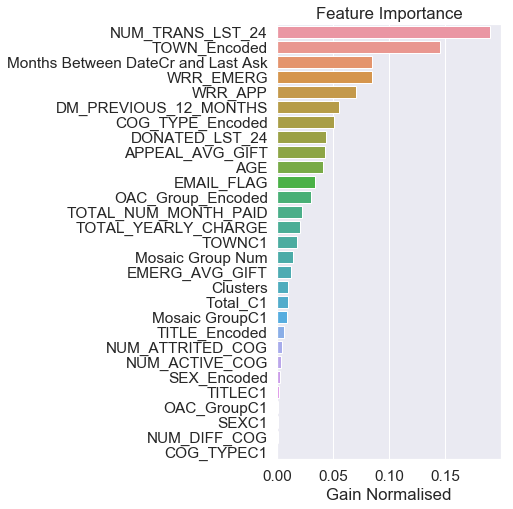

In [57]:
importance_df.sort_values(by="Gain", ascending =False, inplace=True)

plt.figure(figsize=(4,8))
sn.barplot(x="Gain"
           ,y= importance_df.index
           ,data=importance_df)
plt.title("Feature Importance")
plt.xlabel("Gain Normalised")
plt.show()

In [40]:
importance_df.head(13)

,Gain
WRR_EMERG,0.351050
NUM_TRANS_LST_24,0.161773
WRR_APP,0.087292
EMERG_AVG_GIFT,0.062910
AGE,0.054218
APPEAL_AVG_GIFT,0.050191
TOWN_Encoded,0.043340
DM_PREVIOUS_12_MONTHS,0.042778
COG_TYPE_Encoded,0.031073
Months Between DateCr and Last Ask,0.024793


importance_df.to_csv("Data/Feature_Importance.csv", index=True)

## I am now going to do the same to this dataset and add on the customer segments

In [16]:
df_Val = pd.read_csv("Data/Test_Data_Val_Aft_FE.csv")
df_Val = df_Val.set_index("URN")

In [17]:
df_k_means_val = df_Val[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means_val["Recency"] = np.where((df_k_means_val['NUM_TRANS_LST_24']>0),1,0)

X_k_means_val = (df_k_means_val.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [18]:
df_Val = pd.concat([df_Val,pd.Series(K_mean.predict(X_k_means_val), index=df_Val.index)],axis=1)
df_Val.rename(columns={0:"Clusters"}, inplace=True)

## Need to use all of the data to build the model

In [31]:
#Parameters for model:
lgb_params = {'num_leaves': 24, #max number of leaves in one tree
             'min_data_in_leaf': 25, #minimal number of data in one leaf. Can be used to deal with over-fitting
             'objective':'binary',
             #'max_depth': 10,
             'learning_rate': 0.1, #How much each tree effects the overall result.
             "boosting": "gbdt",
             "feature_fraction": 0.8, #LightGBM will select X% of features before training each tree
             "bagging_freq": 1,
             "bagging_fraction": 1, #like feature_fraction, but this will randomly select part of data without resampling
             "bagging_seed": 42,
             "metric": 'AUC',
             "lambda_l2": 0.25,
             "num_threads": 4,
             "verbosity": -1}


features = importance_df.head(13).index

trn_data = lgb.Dataset(X[features], label=y, categorical_feature=(6,8))

num_round = 500
clf = lgb.train(lgb_params, trn_data, num_round, 
                verbose_eval= 100, 
                categorical_feature=(6,8),
                ) #less than 0 means disable

### Save the model to disk

In [55]:
clf.save_model('Parameter_Dictionary/LightGBM.txt')
#load from model:

#bst = lgb.Booster(model_file='mode.txt')

#### Let check the net profit and response rate for the unbalanced dataset

In [32]:
Results_Val = df_Val[["DV", "INCOME"]].copy()
Results_Val["Score"] =  clf.predict(df_Val.drop(["DV", "INCOME"],axis=1), num_iteration=clf.best_iteration)
Results_Val["Score Band"] = Results_Val["Score"].astype(str).str.slice(0,3)

Results_Val.to_csv("Model Outputs/LightGBM_UB_VAL.csv", index=True)

In [33]:
Results_Val_2 = Results_Val.groupby(["Score Band"])["INCOME"].agg(["count", "sum", "mean","median","std" ,"max"])
Results_Val_2 = pd.concat([Results_Val["Score Band"].value_counts().sort_index(), Results_Val_2],axis=1).rename(index=str
                                                                                                                 ,columns={"count":"Donors"
                                                                                                                           ,"Score Band": "Contacted Volume"
                                                                                                                           ,"sum": "Total Value"
                                                                                                                           ,"mean": "Mean Gift"
                                                                                                                           ,"median": "Median Gift"
                                                                                                                           ,"max":"Max Gift"})



In [34]:
Results_Val_2["Cost"]= Results_Val_2["Contacted Volume"] * 2.50
Results_Val_2["Net Profit"] = Results_Val_2["Total Value"] - Results_Val_2["Cost"]
Results_Val_2["RR"] = (Results_Val_2["Donors"]/Results_Val_2["Contacted Volume"])
Results_Val_2

,Contacted Volume,Donors,Total Value,Mean Gift,Median Gift,std,Max Gift,Cost,Net Profit,RR
Score Band,,,,,,,,,,
0.0,1052,37,1259.81,34.048919,30.0,42.947341,200.0,2630.0,-1370.19,0.035171
0.1,2529,99,5577.00,56.333333,30.0,102.322420,1000.0,6322.5,-745.50,0.039146
0.2,3184,126,6080.00,48.253968,22.5,73.584883,500.0,7960.0,-1880.00,0.039573
0.3,776,46,2224.00,48.347826,30.0,75.874229,520.0,1940.0,284.00,0.059278
0.4,462,36,2485.00,69.027778,50.0,73.541237,300.0,1155.0,1330.00,0.077922
0.5,664,30,1115.00,37.166667,20.0,42.945100,200.0,1660.0,-545.00,0.045181
0.6,472,60,2305.00,38.416667,30.0,21.892102,100.0,1180.0,1125.00,0.127119
0.7,95,17,540.00,31.764706,30.0,15.405070,55.0,237.5,302.50,0.178947
0.8,133,20,865.00,43.250000,30.0,53.392169,250.0,332.5,532.50,0.150376
